# Лабораторная работа № 1. (Сучков В.В. ББМО-01-22)
## Реализация Adversarial (DeepFool, FGSM) атаки на модели машинного обучения (Lenet, FC,  NiN)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Подготовка репозитория для среды выполнения Colab

**Adversarial атака — алгоритм действий, целью которого является получение вектора, подающегося на вход алгоритму, на котором алгоритм выдает некорректный выход.**

**Целью такой атаки является подбор такого вектора шума, при наложении которого будут оказываться минимальные изменения по отношению к исходному вектору, но результат определения класса будет не верным**

**В отличие от FGSM DeepFool старается минимизировать шум, при этом сделать так, чтобы классификация была ошибочной.**

In [2]:
# Загрузим репозиторий в среду выполнения
!cp -r /content/drive/MyDrive/Учеба/Семестр\ №\ 3/Анализ\ защищенности\ систем\ искусственного\ интеллекта/prz_2/* /content/
# Удалим лишние файлы
!rm  *.ipynb

# Ход работы
### Импортируем библиотеки


In [11]:
import numpy as np
import os, torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, model_train, model_eval, evaluate_attack, display_attack

### Устанавливаем rand_seed и выбираем устройство выполнения


In [4]:
# Устанавливаем случайное число
rand_seed = 18
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

### Загружаем датасет MNIST и предобрабатываем его


In [5]:
# Загружаем датасет MNIST
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

mnist_min, mnist_max = get_clip_bounds(mnist_mean,
                                       mnist_std,
                                       mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=0.0,
        std=np.divide(1.0, mnist_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, mnist_std),
        std=1.0)])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True,
                            download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])

mnist_test = datasets.MNIST(root='datasets/mnist', train=False,
                            download=True, transform=mnist_tf)

100%|██████████| 9912422/9912422 [00:00<00:00, 154312744.71it/s]


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 125920679.65it/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39879433.73it/s]

Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6741163.75it/s]


Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



### Загружаем датасет CIFAR-10 и предобрабатываем его


In [6]:
# Загрузим датасет CIFAR-10
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean,
                                       cifar_std,
                                       cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=cifar_mean,
        std=cifar_std)])

cifar_tf_train = transforms.Compose([
    transforms.RandomCrop(
        size=cifar_dim,
        padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=cifar_mean,
        std=cifar_std)])

cifar_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=np.divide(1.0, cifar_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, cifar_mean),
        std=[1.0, 1.0, 1.0])])

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True,
                              download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False,
                              download=True, transform=cifar_tf)
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:04<00:00, 35210003.84it/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


### Настраиваем гиперпараметры

In [7]:
# Установимм размер разбивки на 64 батча
batch_size = 64
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size,
                                shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size,
                              shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size,
                               shuffle=False, num_workers=workers)

cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size,
                                shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size,
                              shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size,
                               shuffle=False, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# Устанавливаем параметры для обучения
train_model = True

epochs = 50
epochs_nin = 100

lr = 0.004
lr_nin = 0.01
lr_scale = 0.5

momentum = 0.9

print_step = 5

deep_batch_size = 10
deep_num_classes = 10
deep_overshoot = 0.02
deep_max_iters = 50

deep_args = [deep_batch_size, deep_num_classes,
             deep_overshoot, deep_max_iters]

if not os.path.isdir('weights/deepfool'):
    os.makedirs('weights/deepfool', exist_ok=True)

if not os.path.isdir('weights/fgsm'):
    os.makedirs('weights/fgsm', exist_ok=True)

## **Загрузить и оценить стойкость модели Network-In-Network Model к FGSM и DeepFool атакам на основе датасета CIFAR-10**


In [9]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('cpu')))
evaluate_attack('cifar_nin_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool.csv', 'results', device, model,
cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
if device.type == 'cuda': torch.cuda.empty_cache()

FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


**Исходя из результатов проверки атаки, можно сказать следующие:**
* 1 - Ошибка вносимая методом Deepfool - выше, чем FGSM
* 2 - Время, которое при этом затрачивается на одну картинку у метода DeepFool гораздо выше, т.к. данный метод доводит дисперсию шума до минимума
* 3 - Мера отвечающая за интенсивность шума (дисперсию шума) у метода DeepFool ниже, что значит, что шум менее заметен, чем при FGSM

## **Загрузить и оценить стойкость модели LeNet к FGSM и DeepFool атакам на основе датасета CIFAR-10**

In [10]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))
evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
if device.type == 'cuda': torch.cuda.empty_cache()

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


**Исходя из результатов проверки атаки, можно сказать следующие:**
* 1 - Ошибка вносимая методом FGSM - выше, чем DeepFool
* 2 - Время, которое при этом затрачивается на одну картинку у метода DeepFool гораздо выше, т.к. данный метод доводит дисперсию шума до минимума
* 3 - Мера отвечающая за интенсивность шума (дисперсию шума) у метода DeepFool незначительно ниже

В целом, для LeNet и датасета CIFAR проще использовать FGSM, т.к. мы экономим время и вносим большую ошибку

## **Выполнить оценку атакующих примеров для сетей:**
* 1 - LeNet (MNIST)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


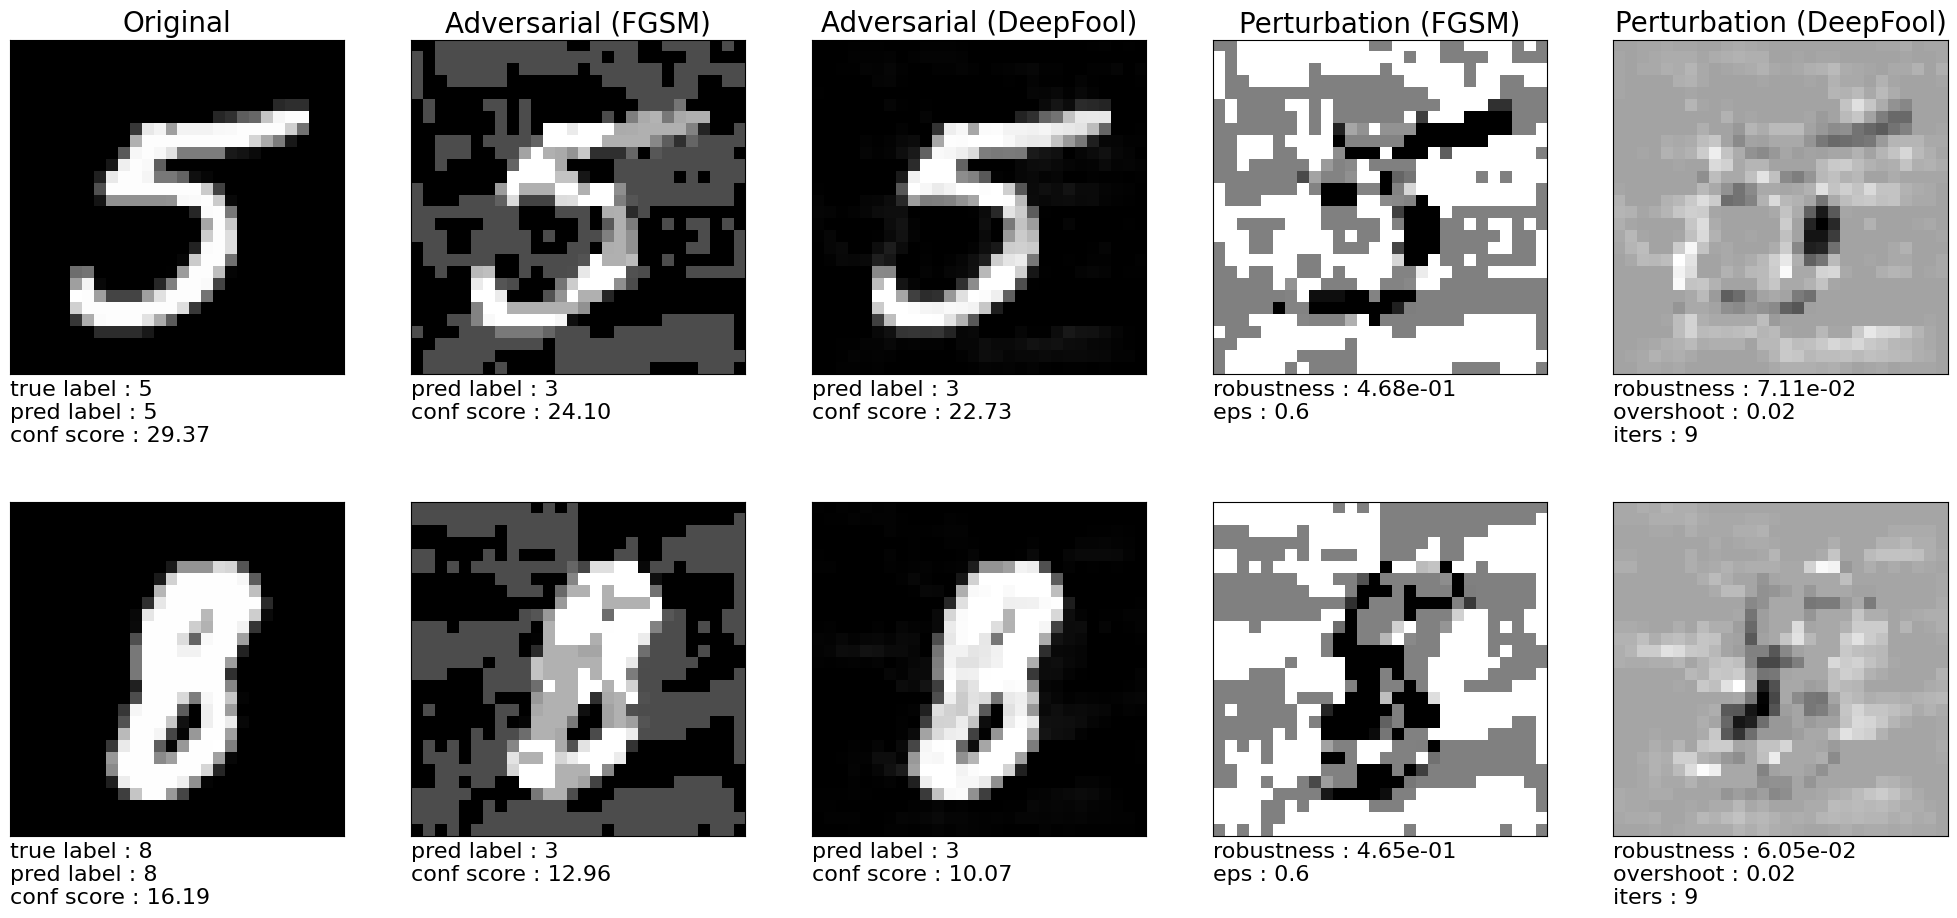

In [12]:
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()


**Можно увидеть, что шумовая карта DeepFool менне заметна и robustness (дисперсия) меньше, однако из примера выше видно что ошибка от FGSM была больше при меньшем времени, затраченном на реализацию атаки**


* 2 - FCNet

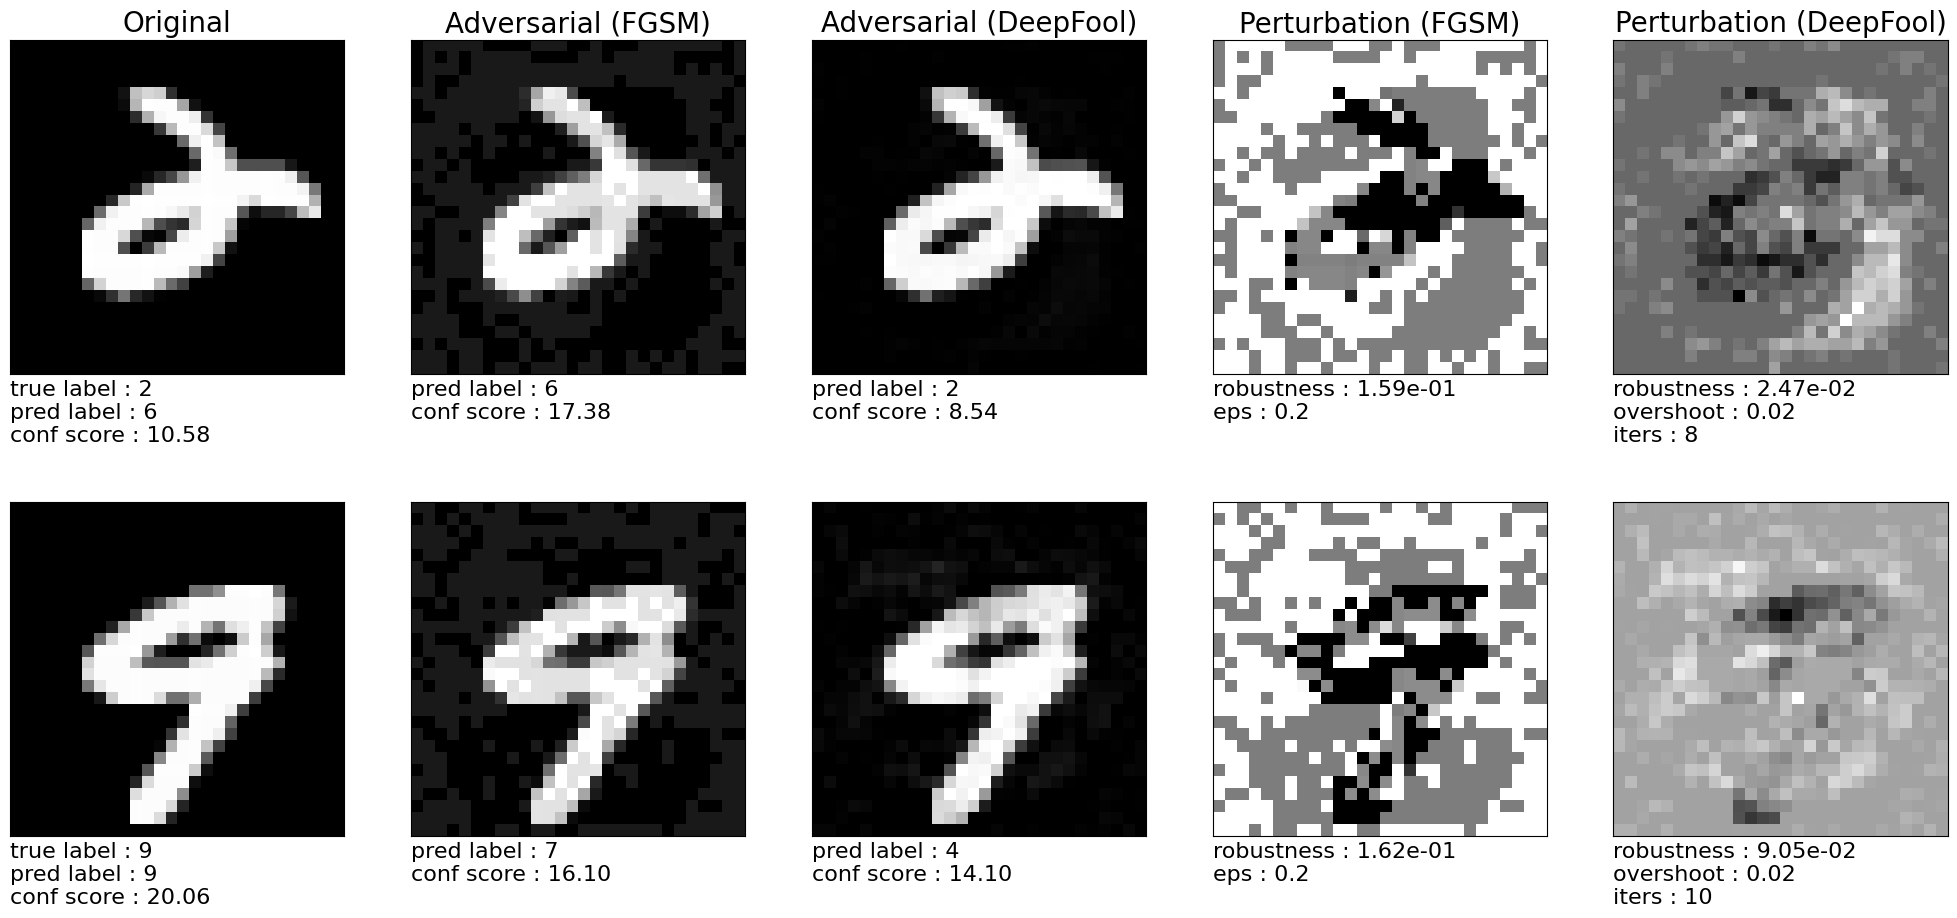

In [17]:
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()

**В виду уменьшения fgsm_eps для данного прмера - уменьшиласб дисперсия шума и он стал менее интенсивен и заметен.**

**Таким образом, возникает предположение о том, что fgsm_eps - мера от которой зависит интенсивность шумовой карты FGSM**

* 3 - NiN

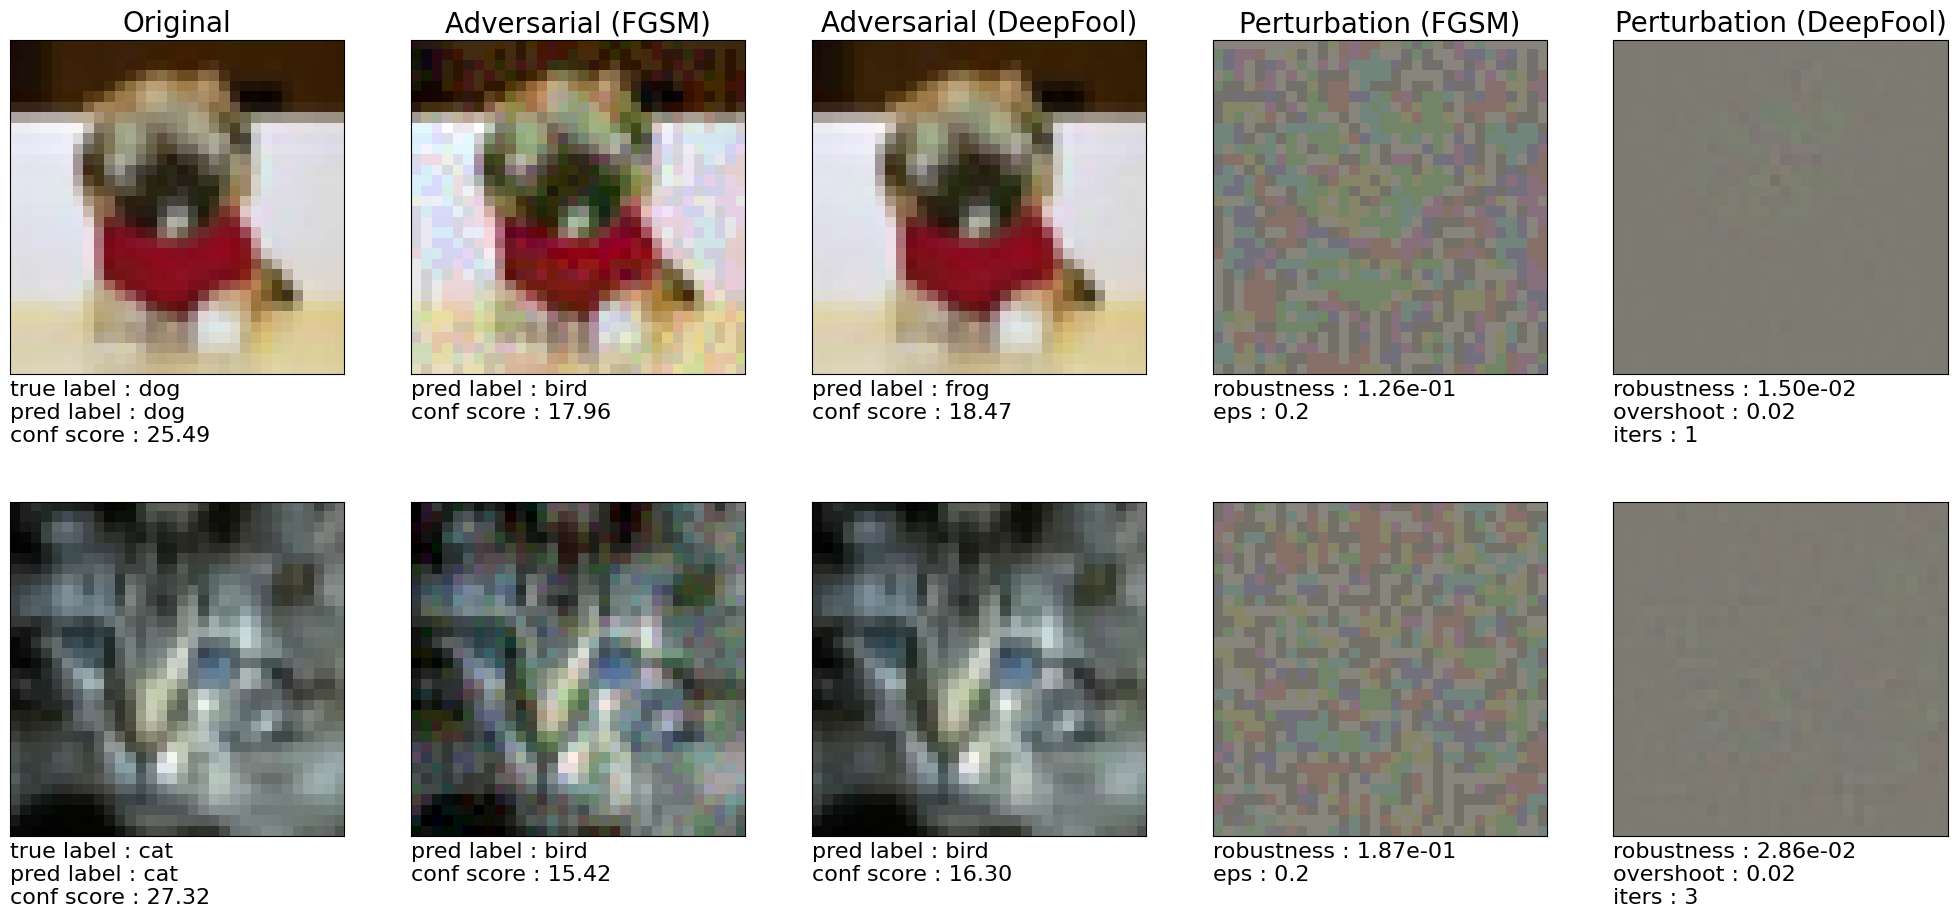

In [18]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11,
label_map=cifar_classes)
if device.type == 'cuda': torch.cuda.empty_cache()

**FGSM вносит больший шум чем DeepFool**

* 4 - Lenet (CIFAR-10)

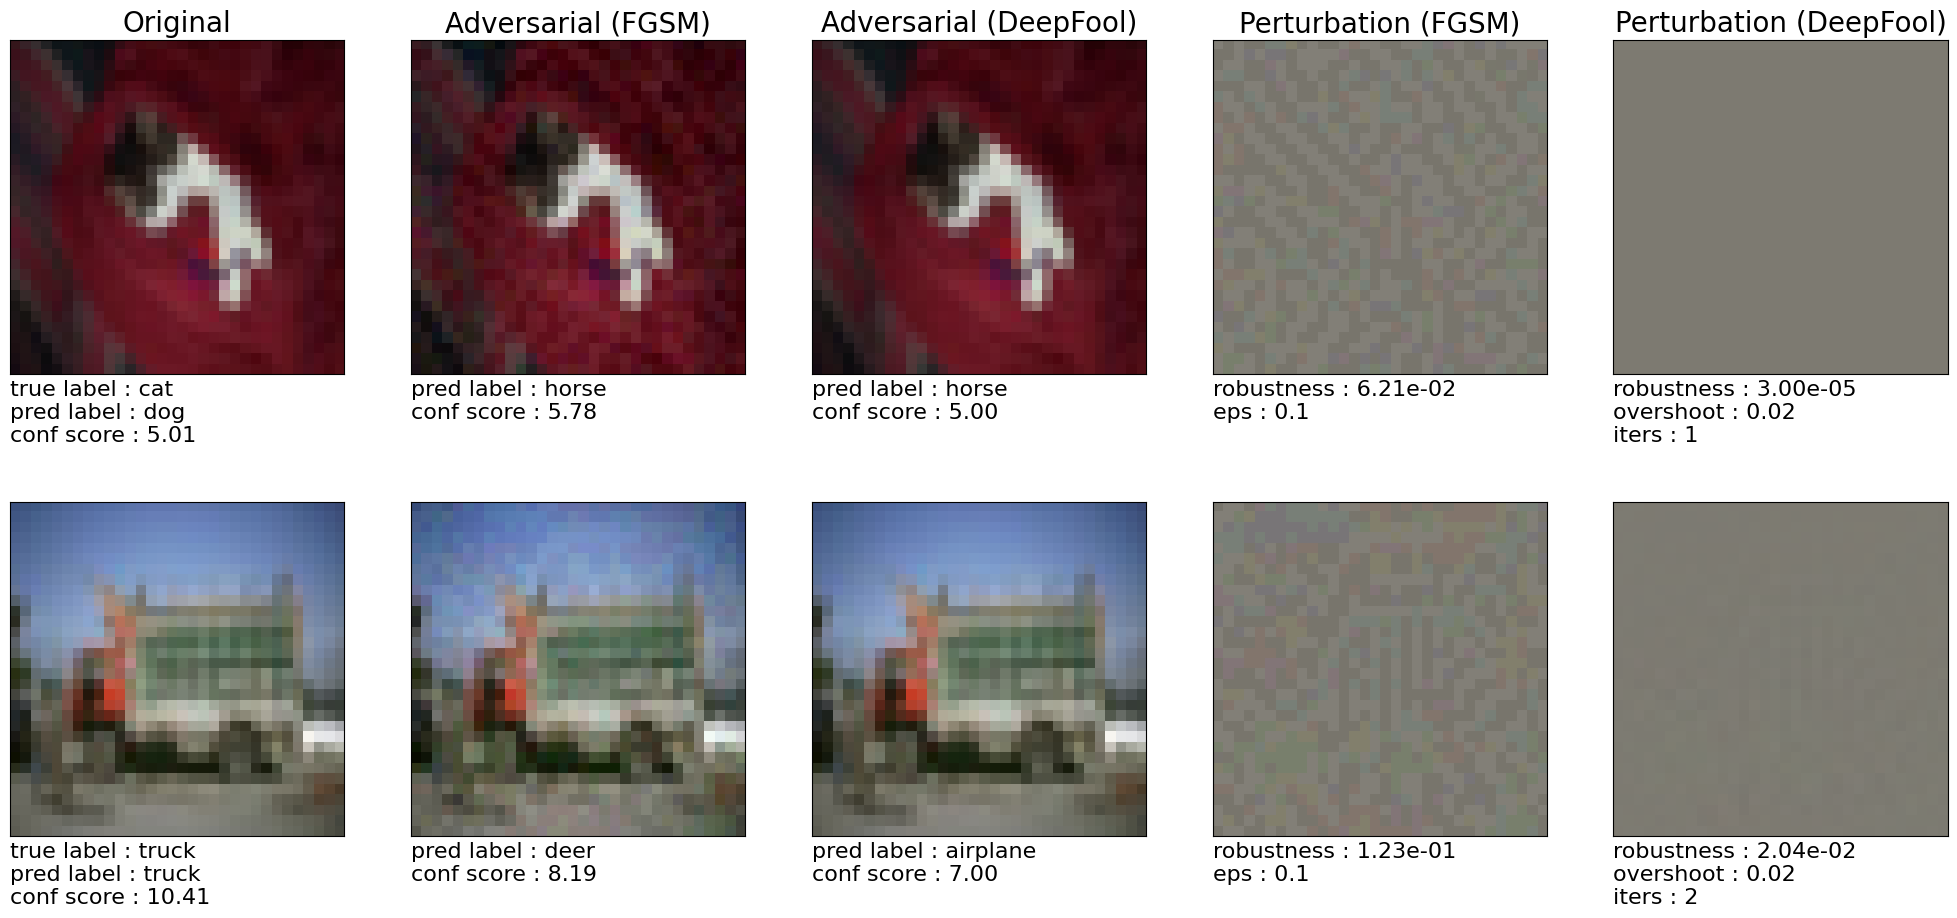

In [19]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11,
label_map=cifar_classes)
if device.type == 'cuda': torch.cuda.empty_cache()

## **Выявление закономерности результатов атаки от имзменения eps**
### **LENET**

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


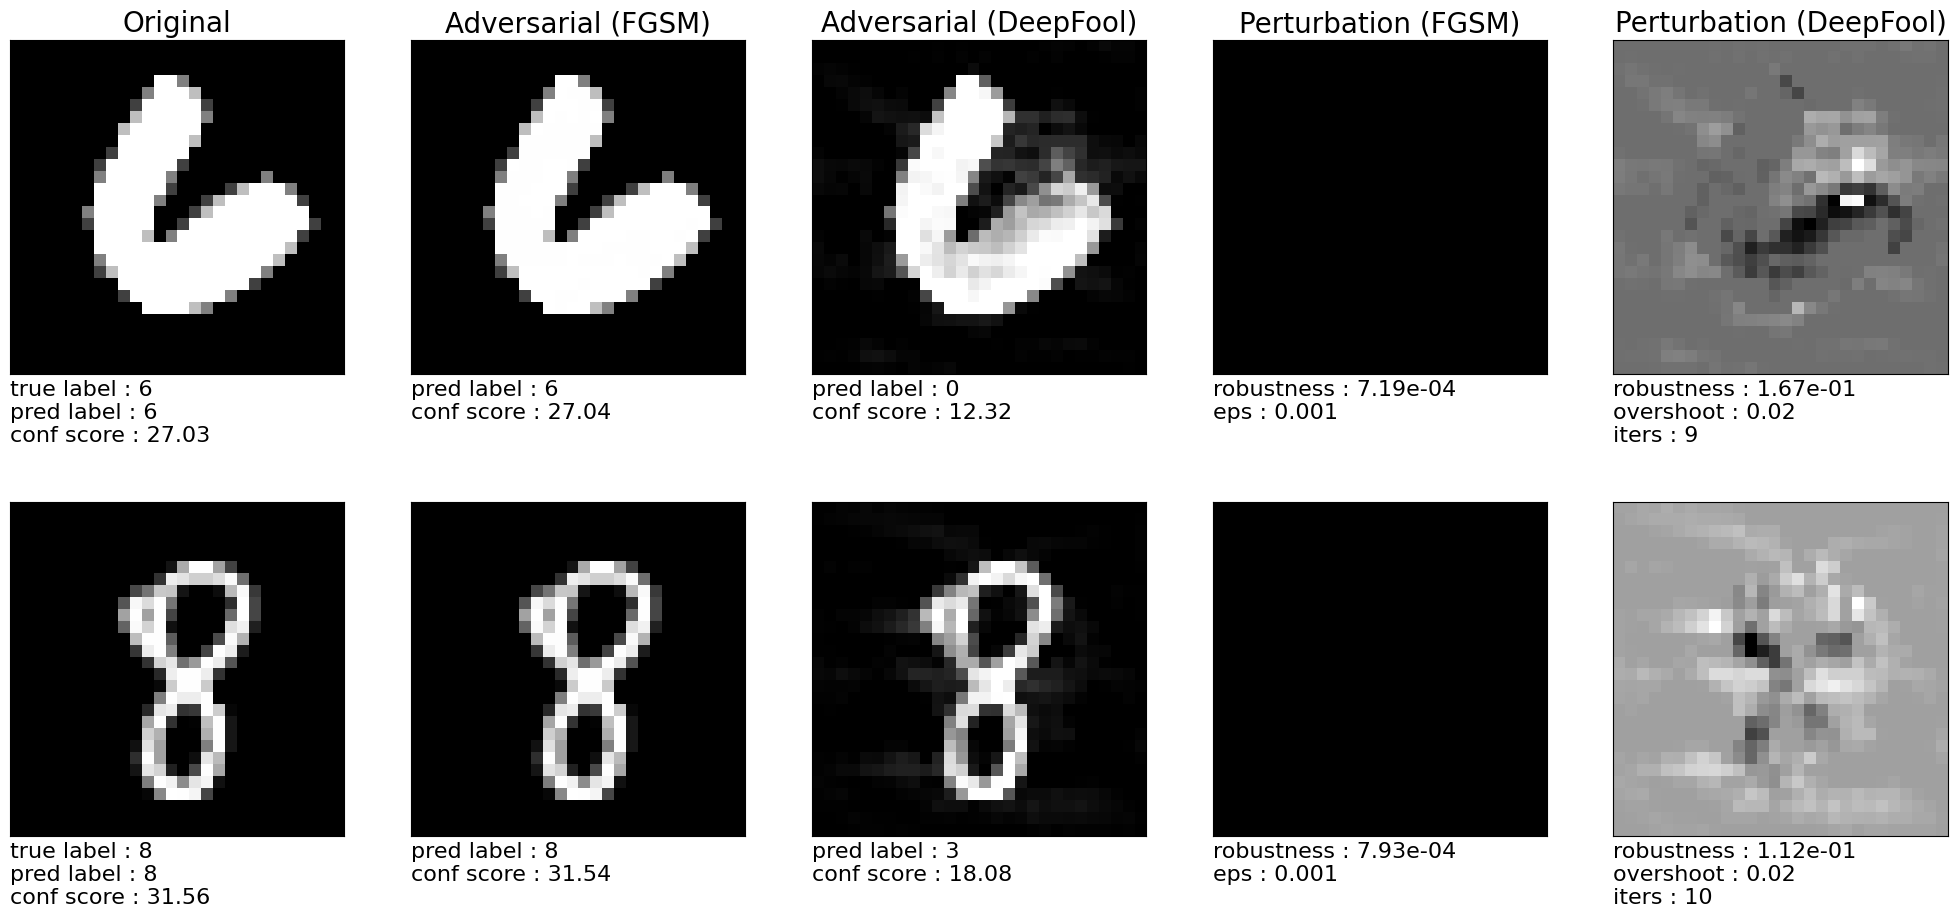

eps:  0.001


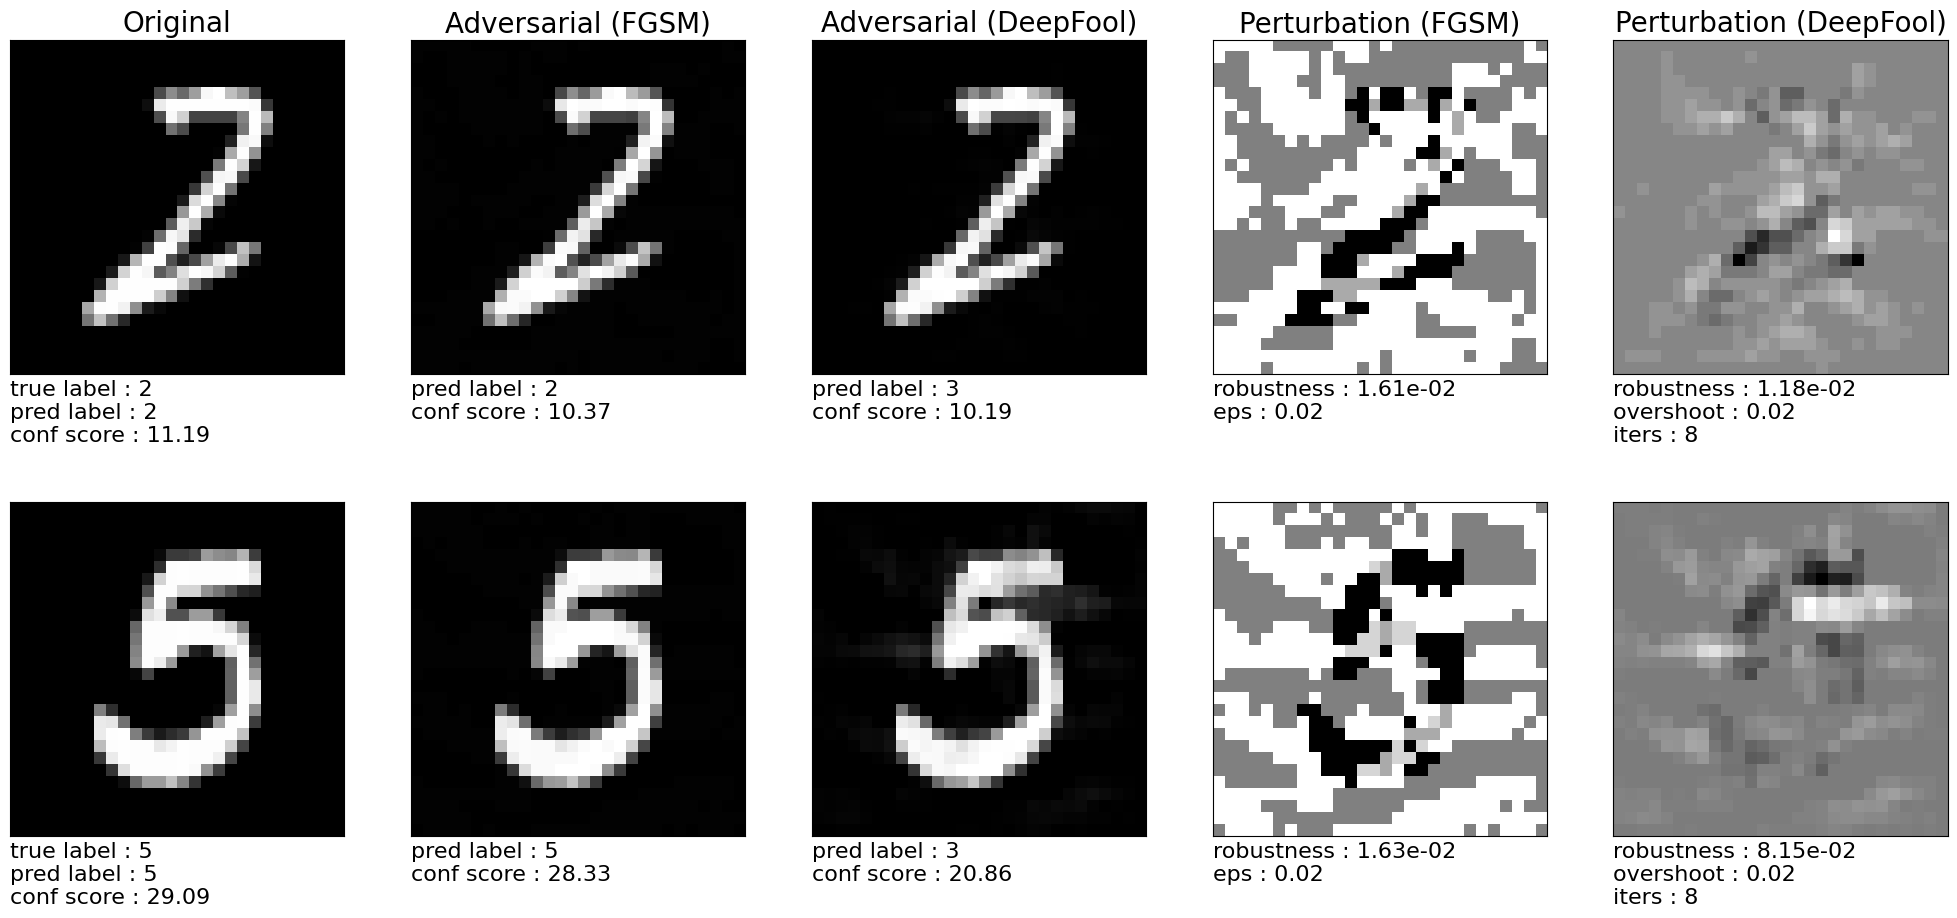

eps:  0.02


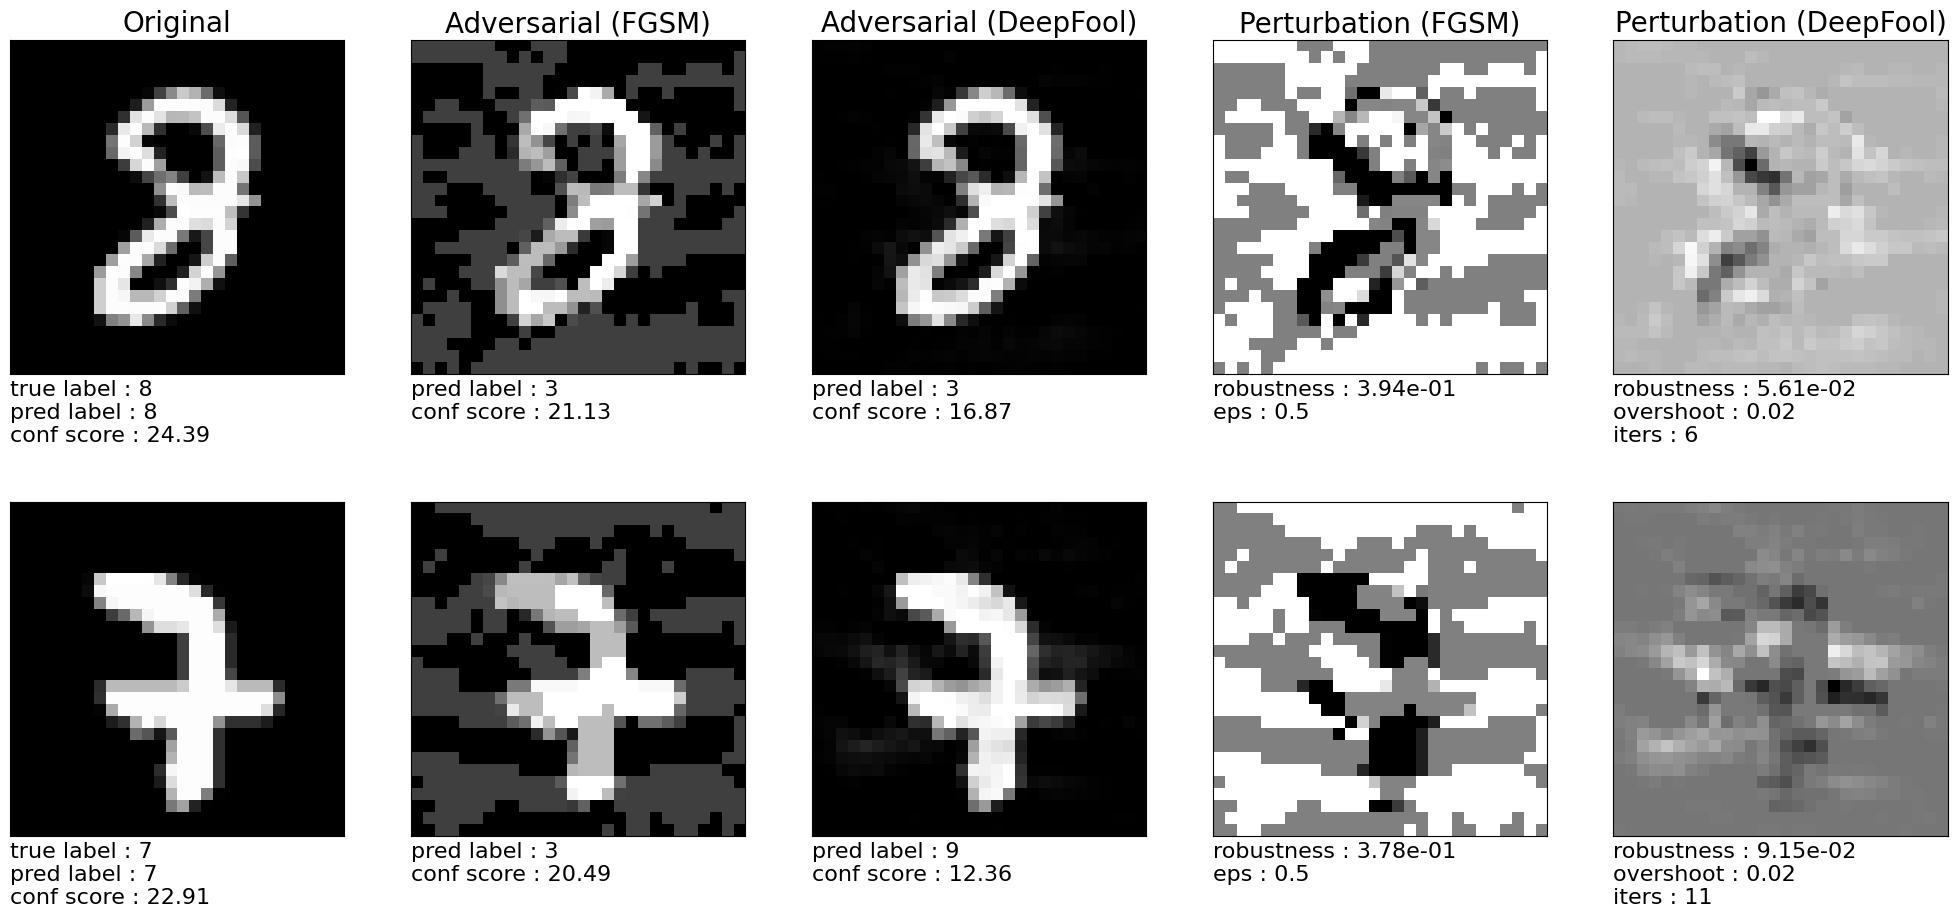

eps:  0.5


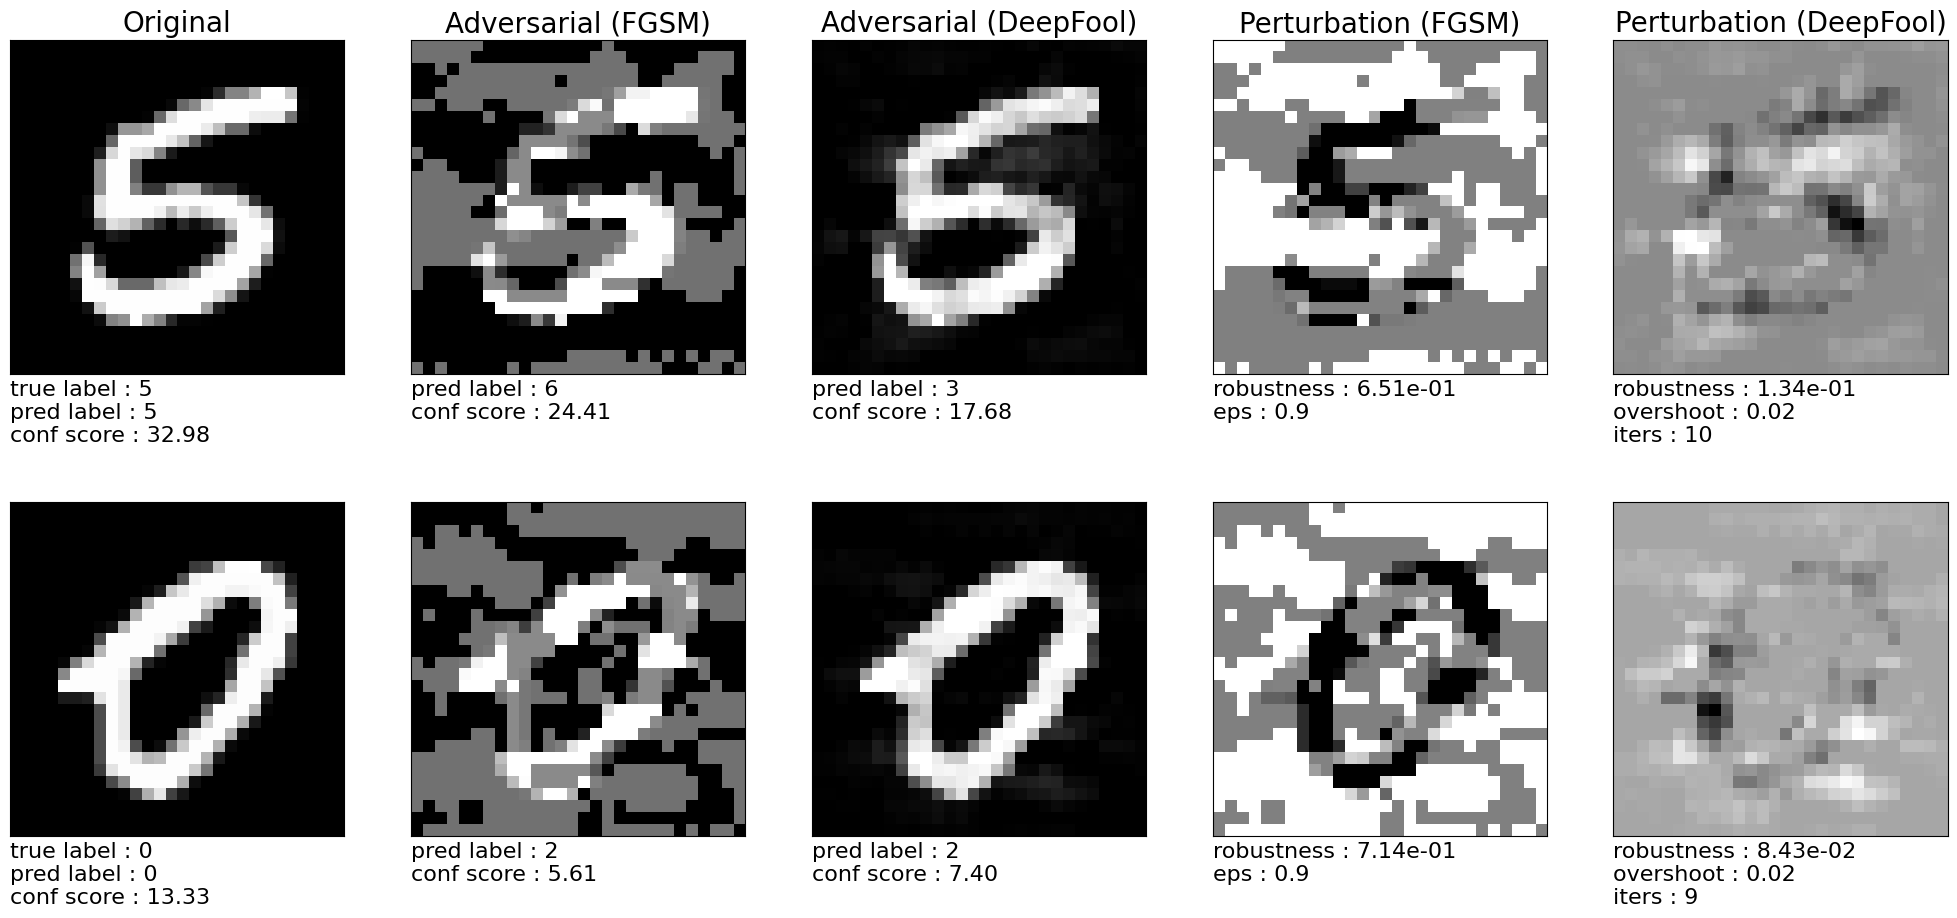

eps:  0.9


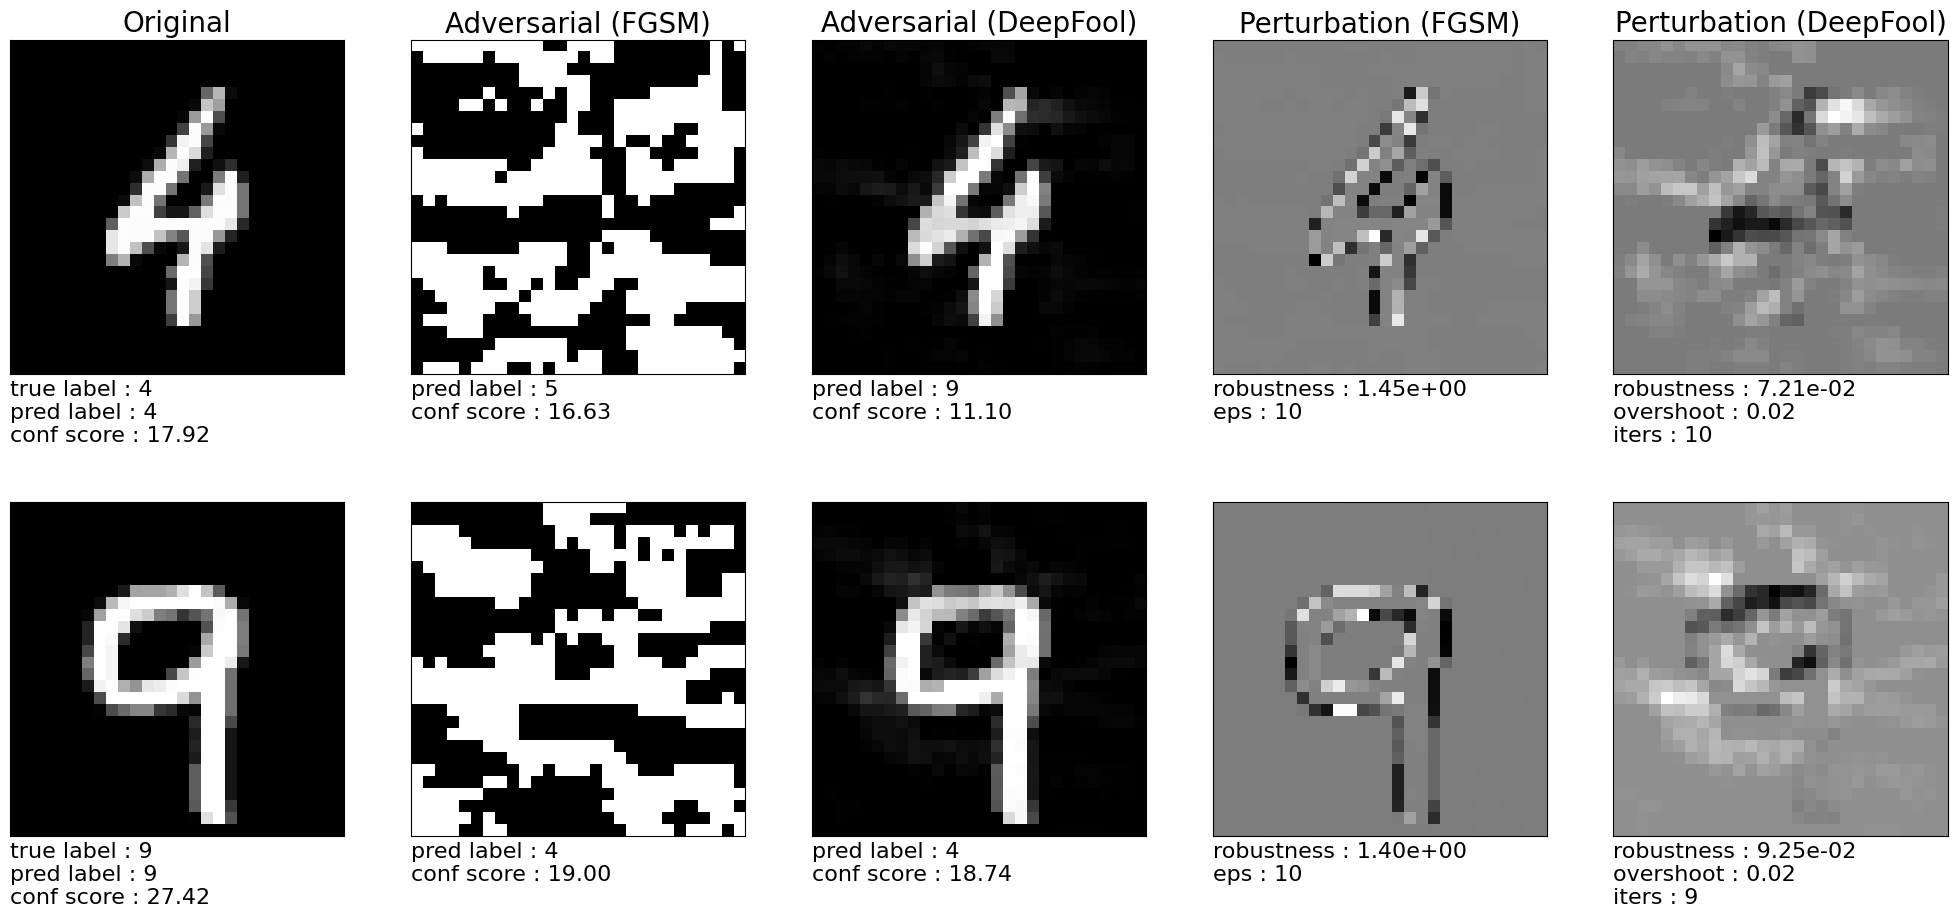

eps:  10


In [28]:
fgsm_eps_arr = [0.001, 0.02, 0.5, 0.9, 10]
for fgsm_eps in fgsm_eps_arr:
  model = LeNet_MNIST().to(device)
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
  display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
  if device.type == 'cuda': torch.cuda.empty_cache()
  print("eps: ", fgsm_eps)


### **NIN**

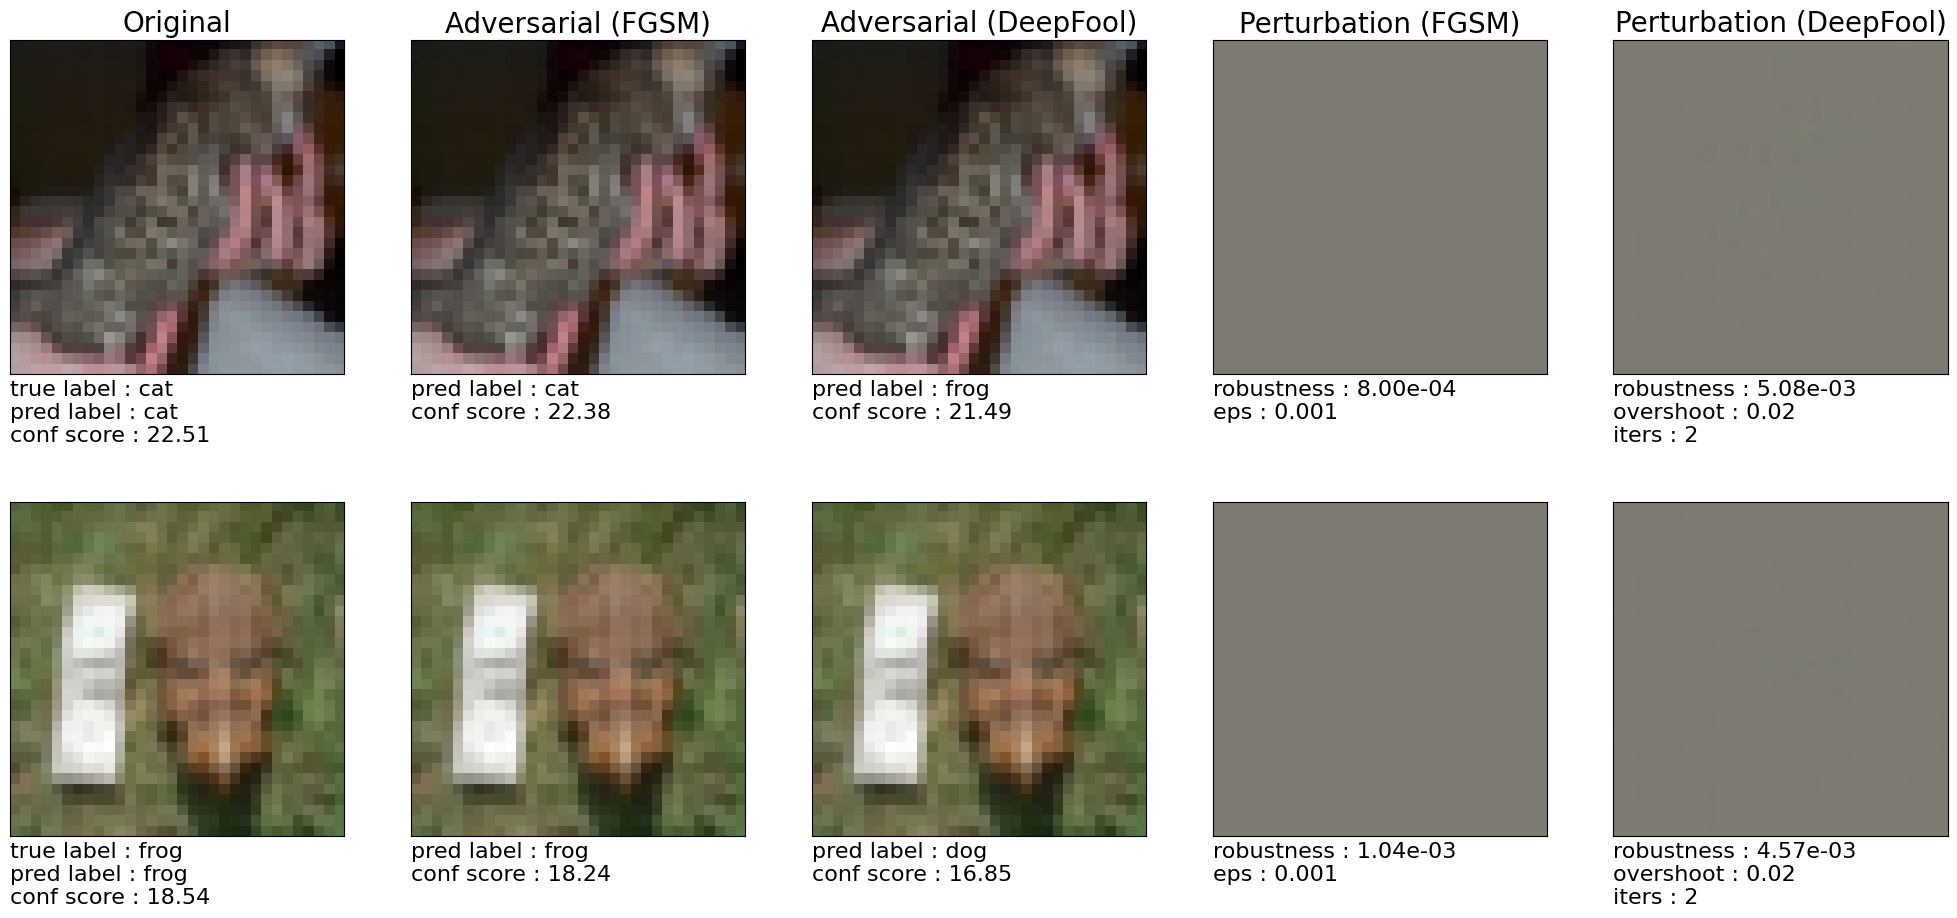

eps:  0.001


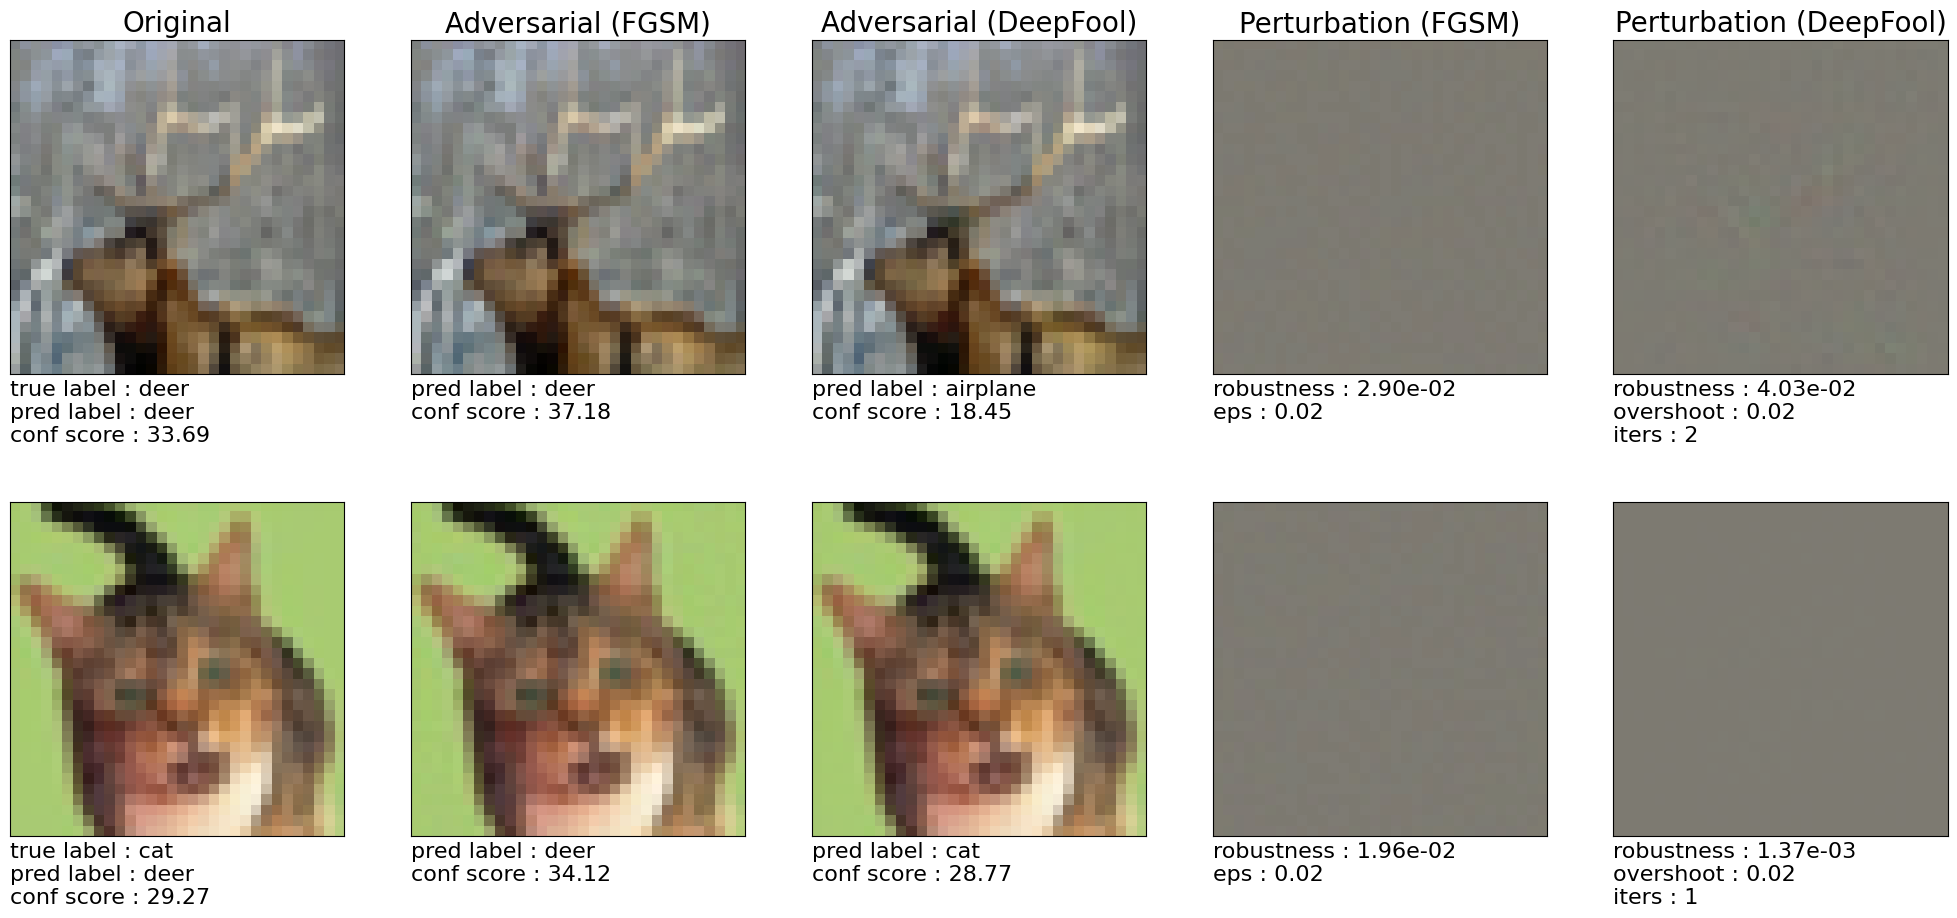

eps:  0.02


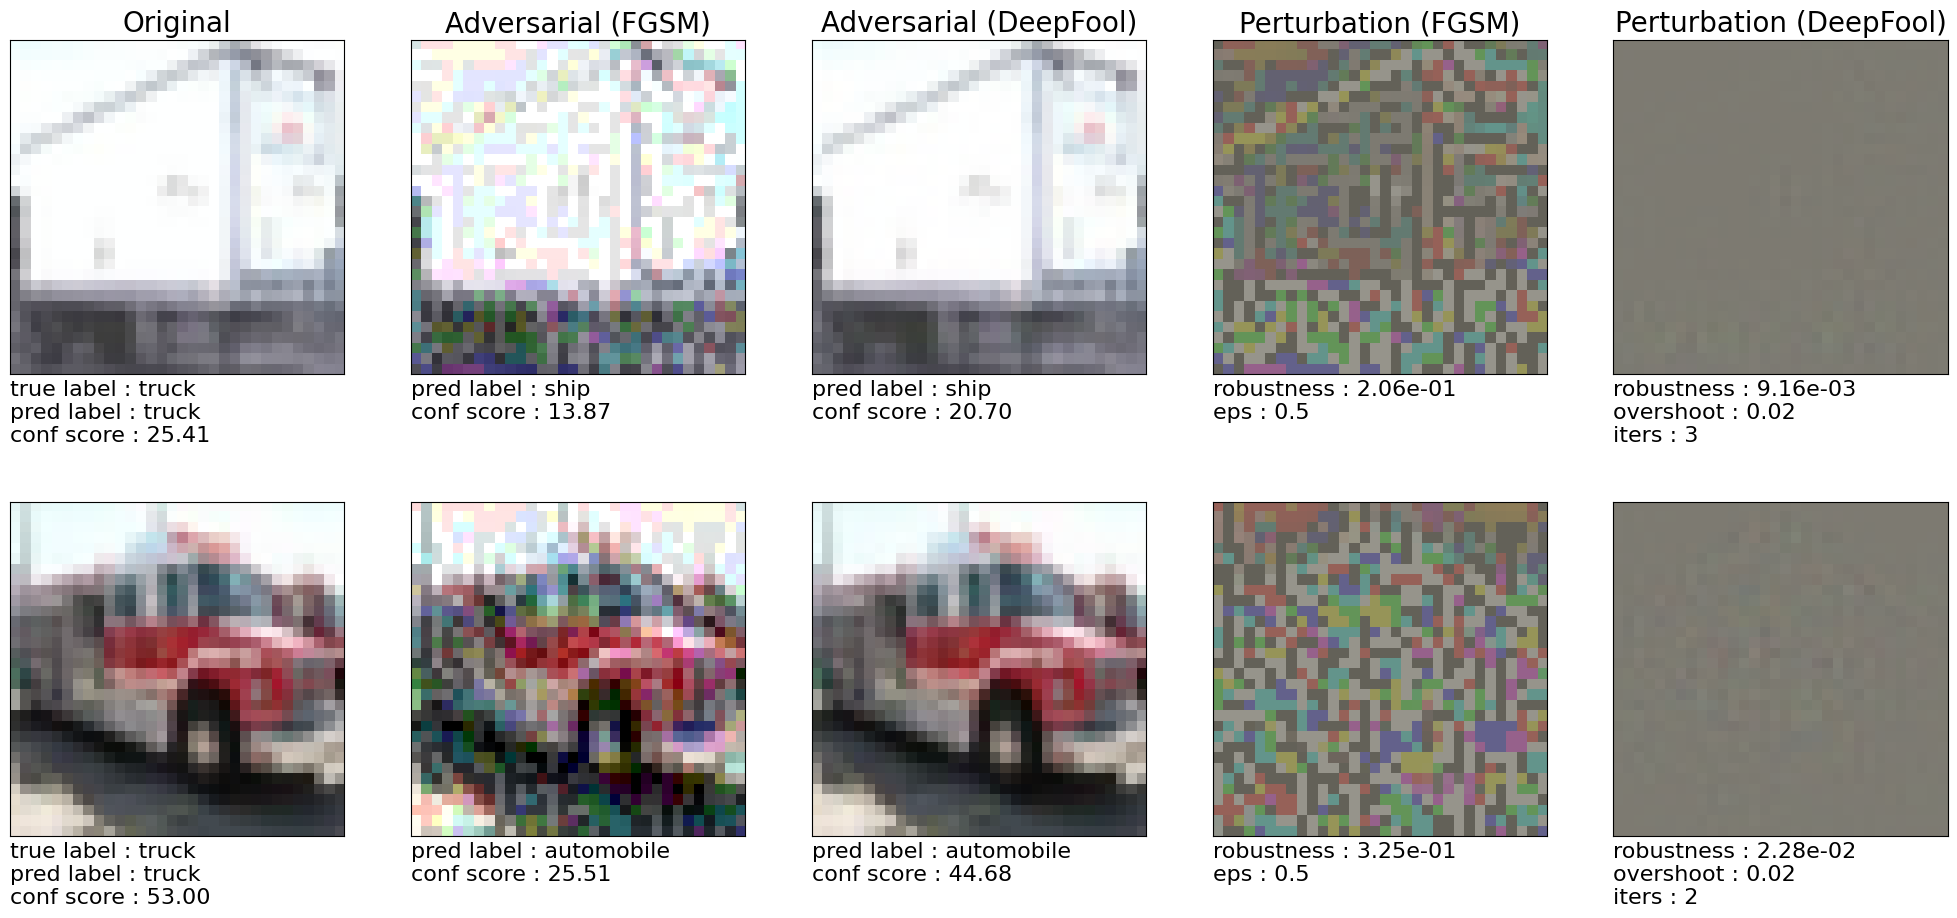

eps:  0.5


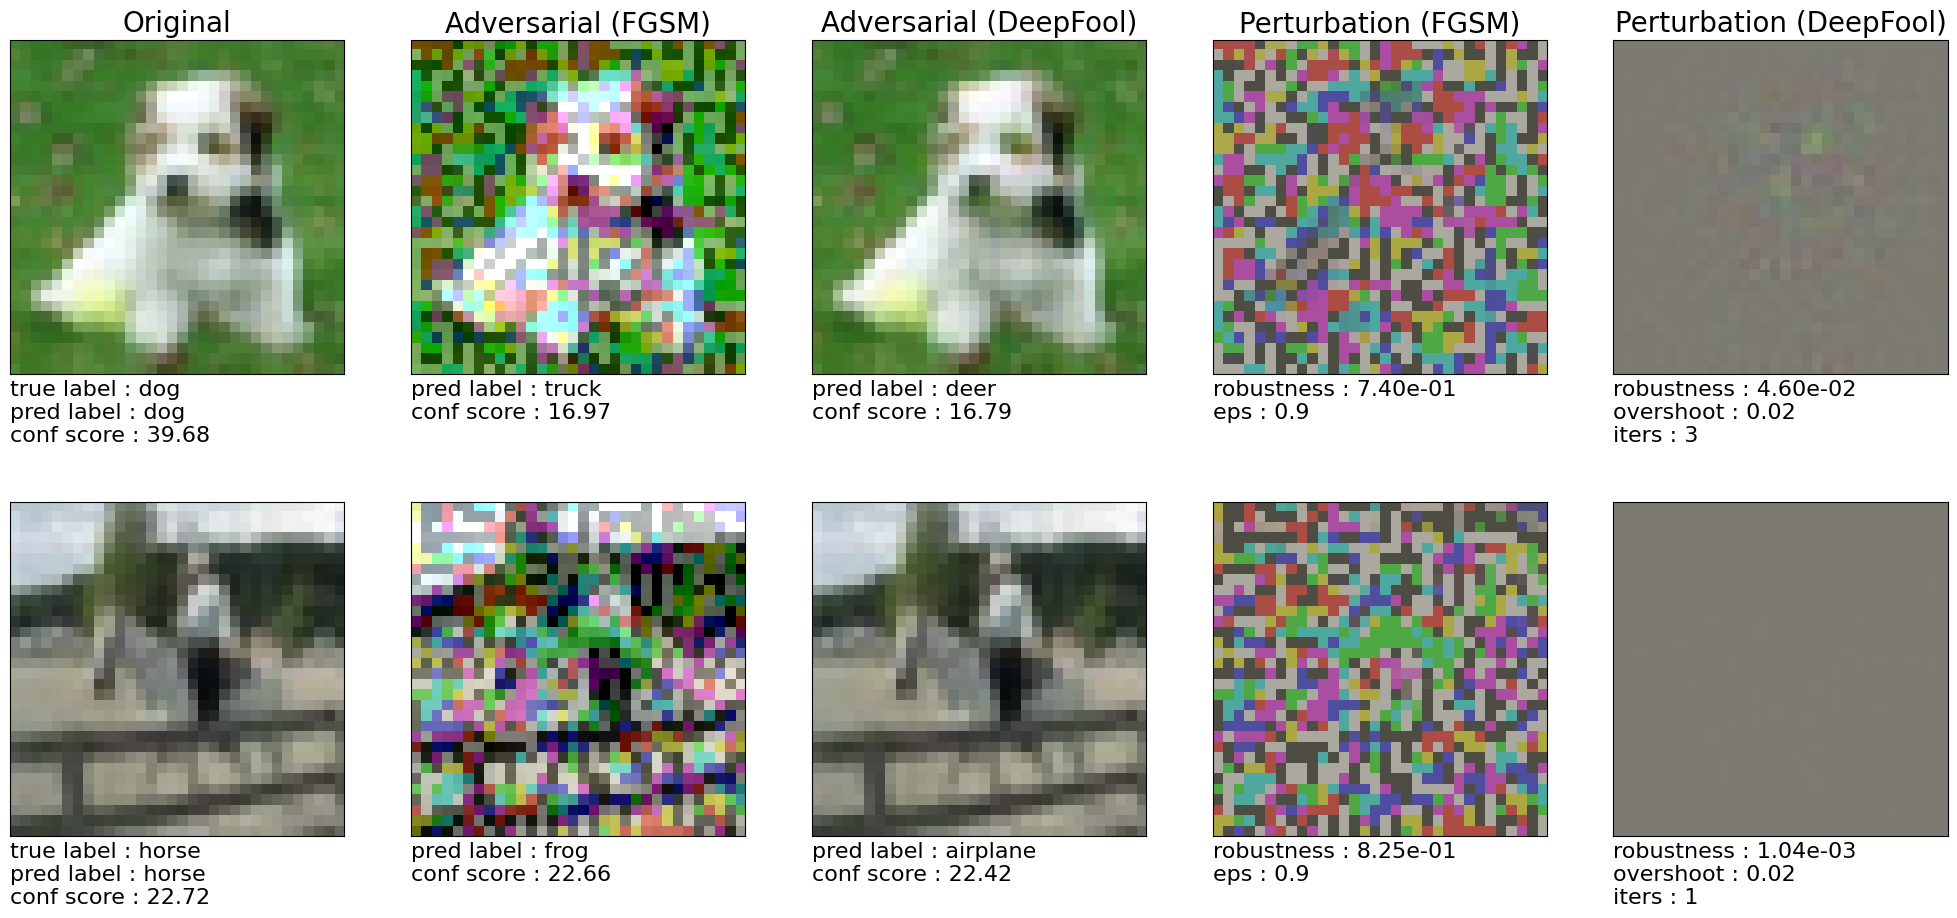

eps:  0.9


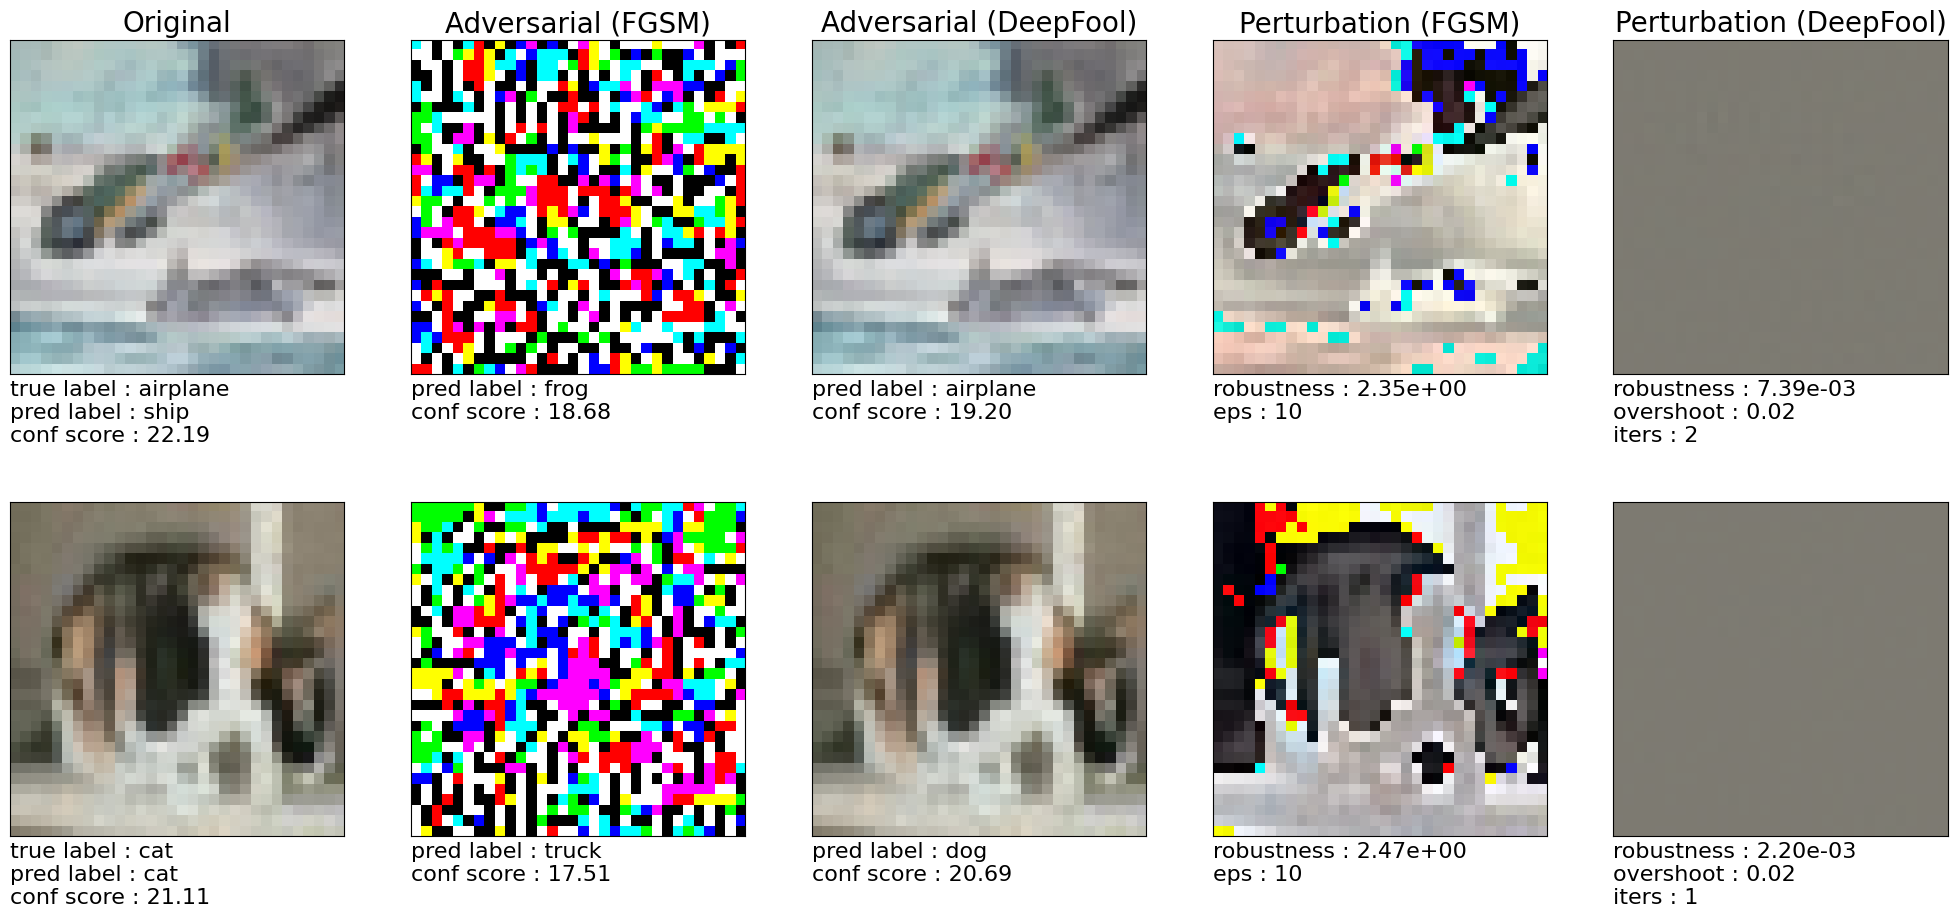

eps:  10


In [32]:
fgsm_eps_arr = [0.001, 0.02, 0.5, 0.9, 10]
for fgsm_eps in fgsm_eps_arr:
  model = Net().to(device)
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
  display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11,
  label_map=cifar_classes)
  if device.type == 'cuda': torch.cuda.empty_cache()
  print("eps: ", fgsm_eps)

### **FC**

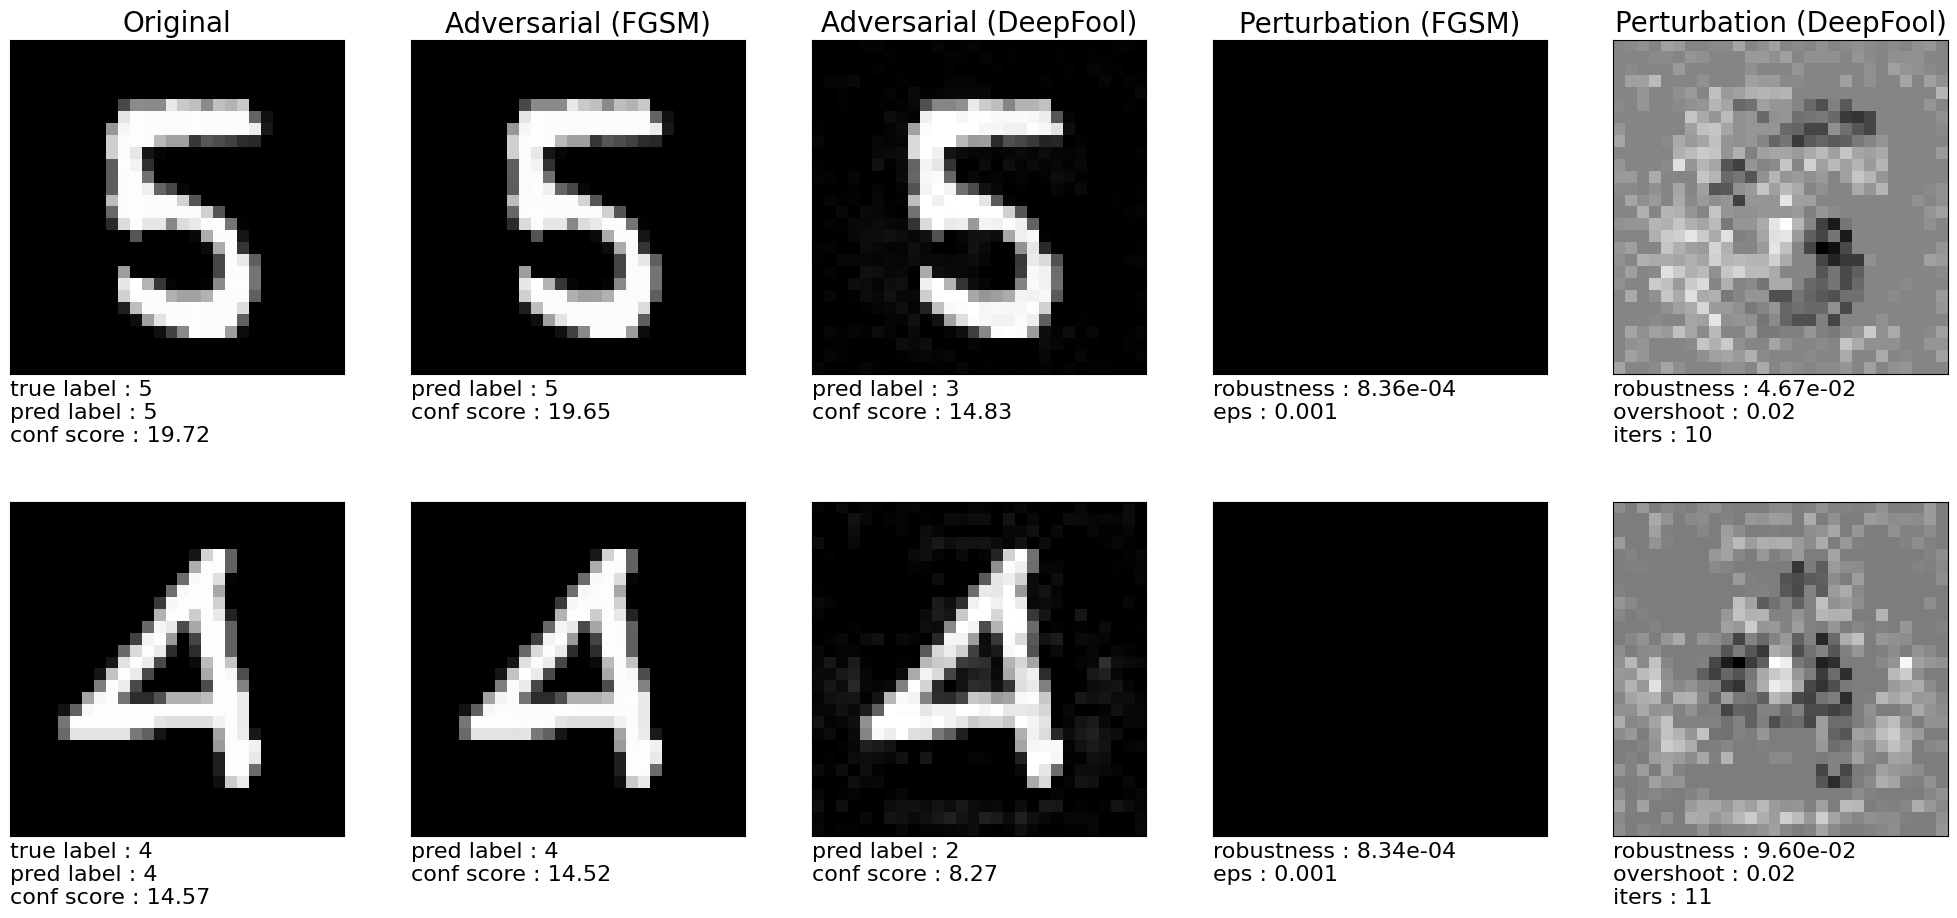

eps:  0.001


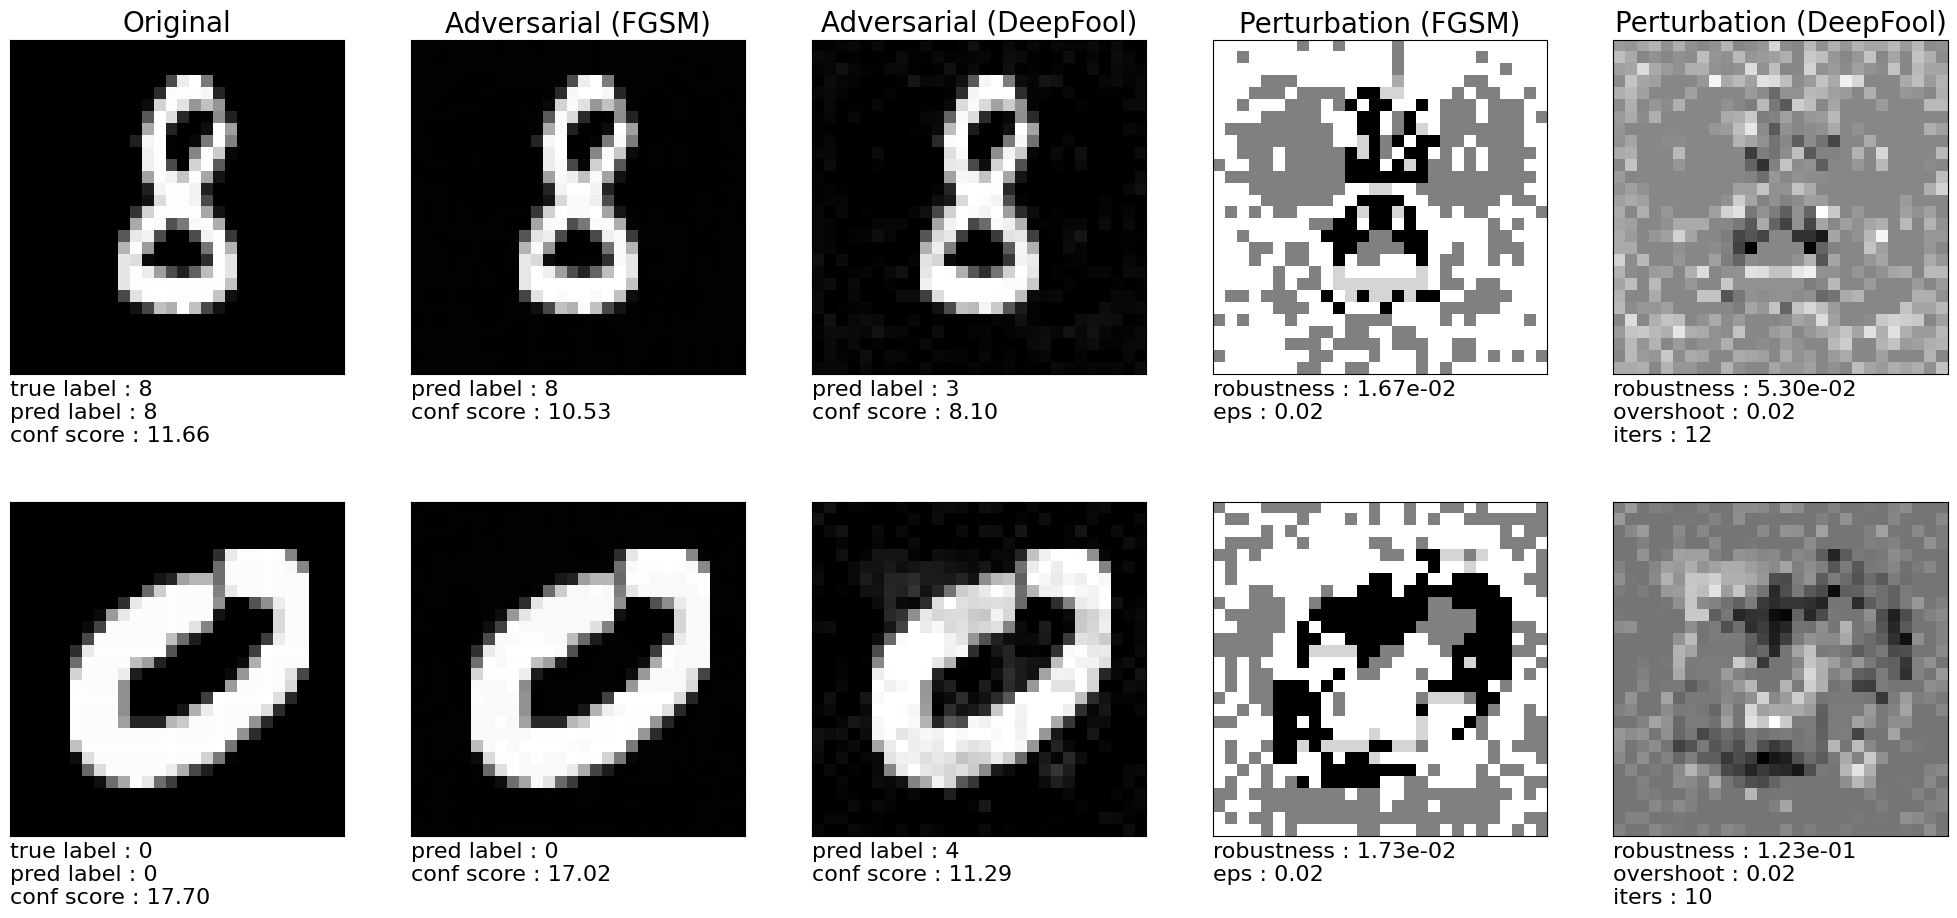

eps:  0.02


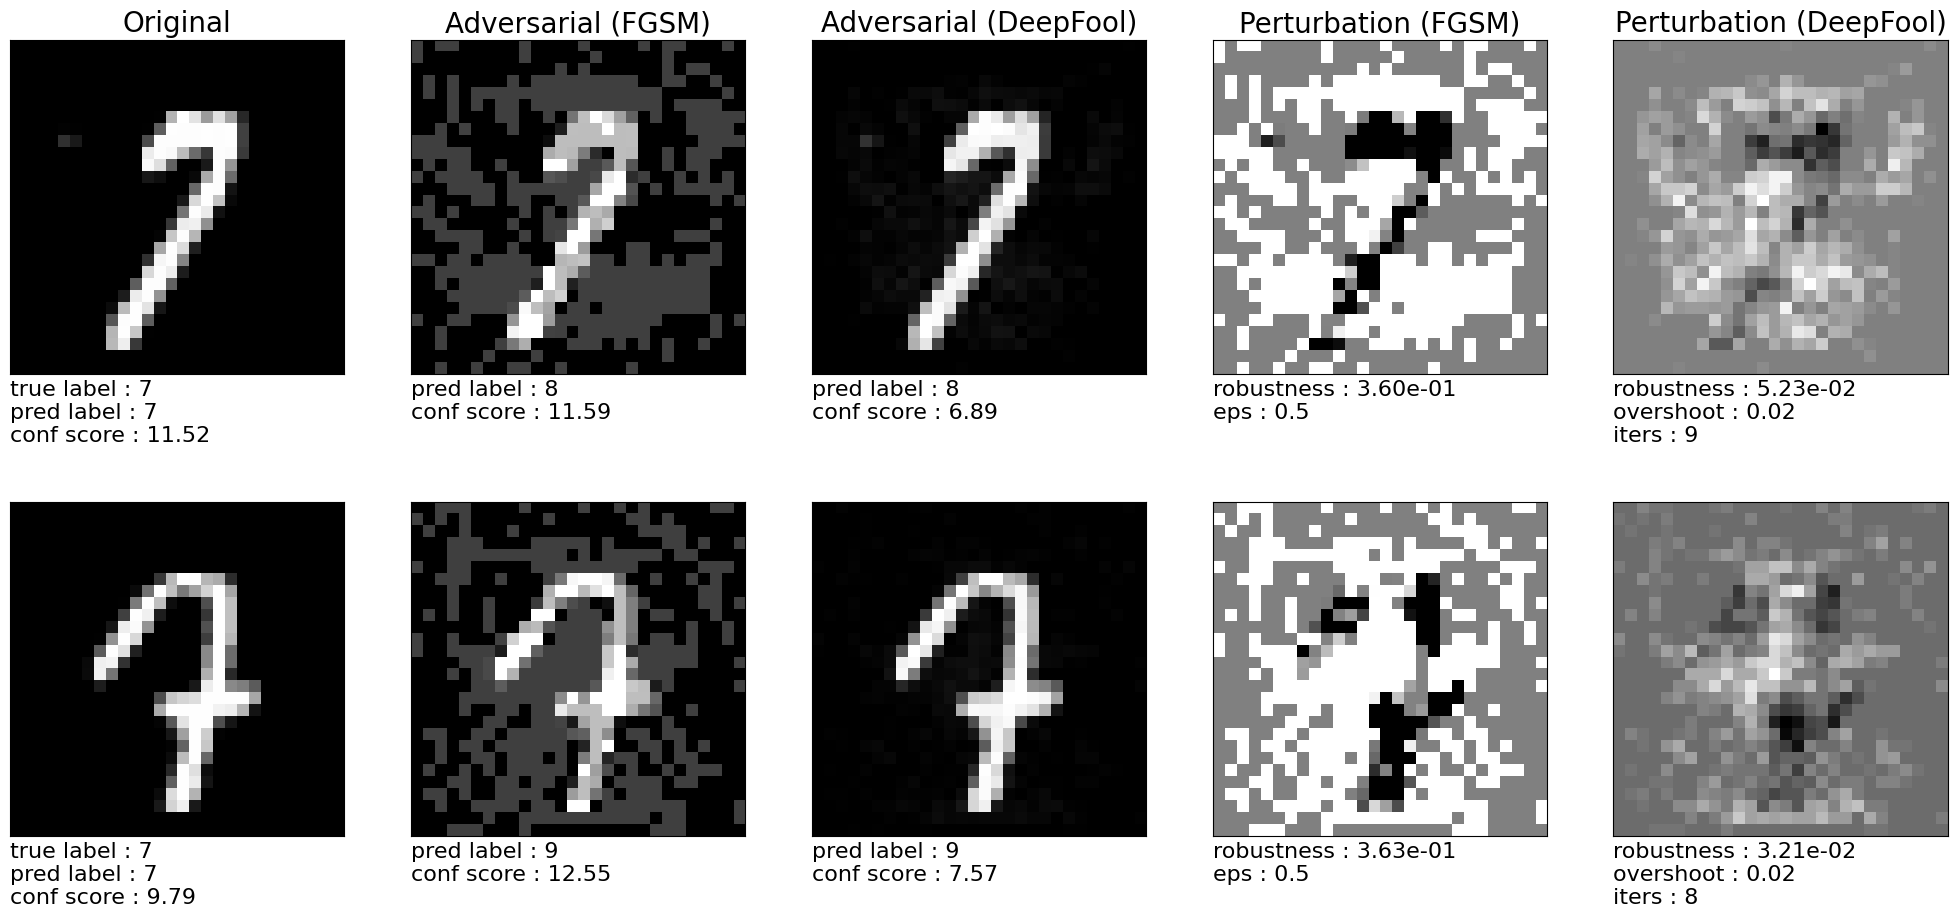

eps:  0.5


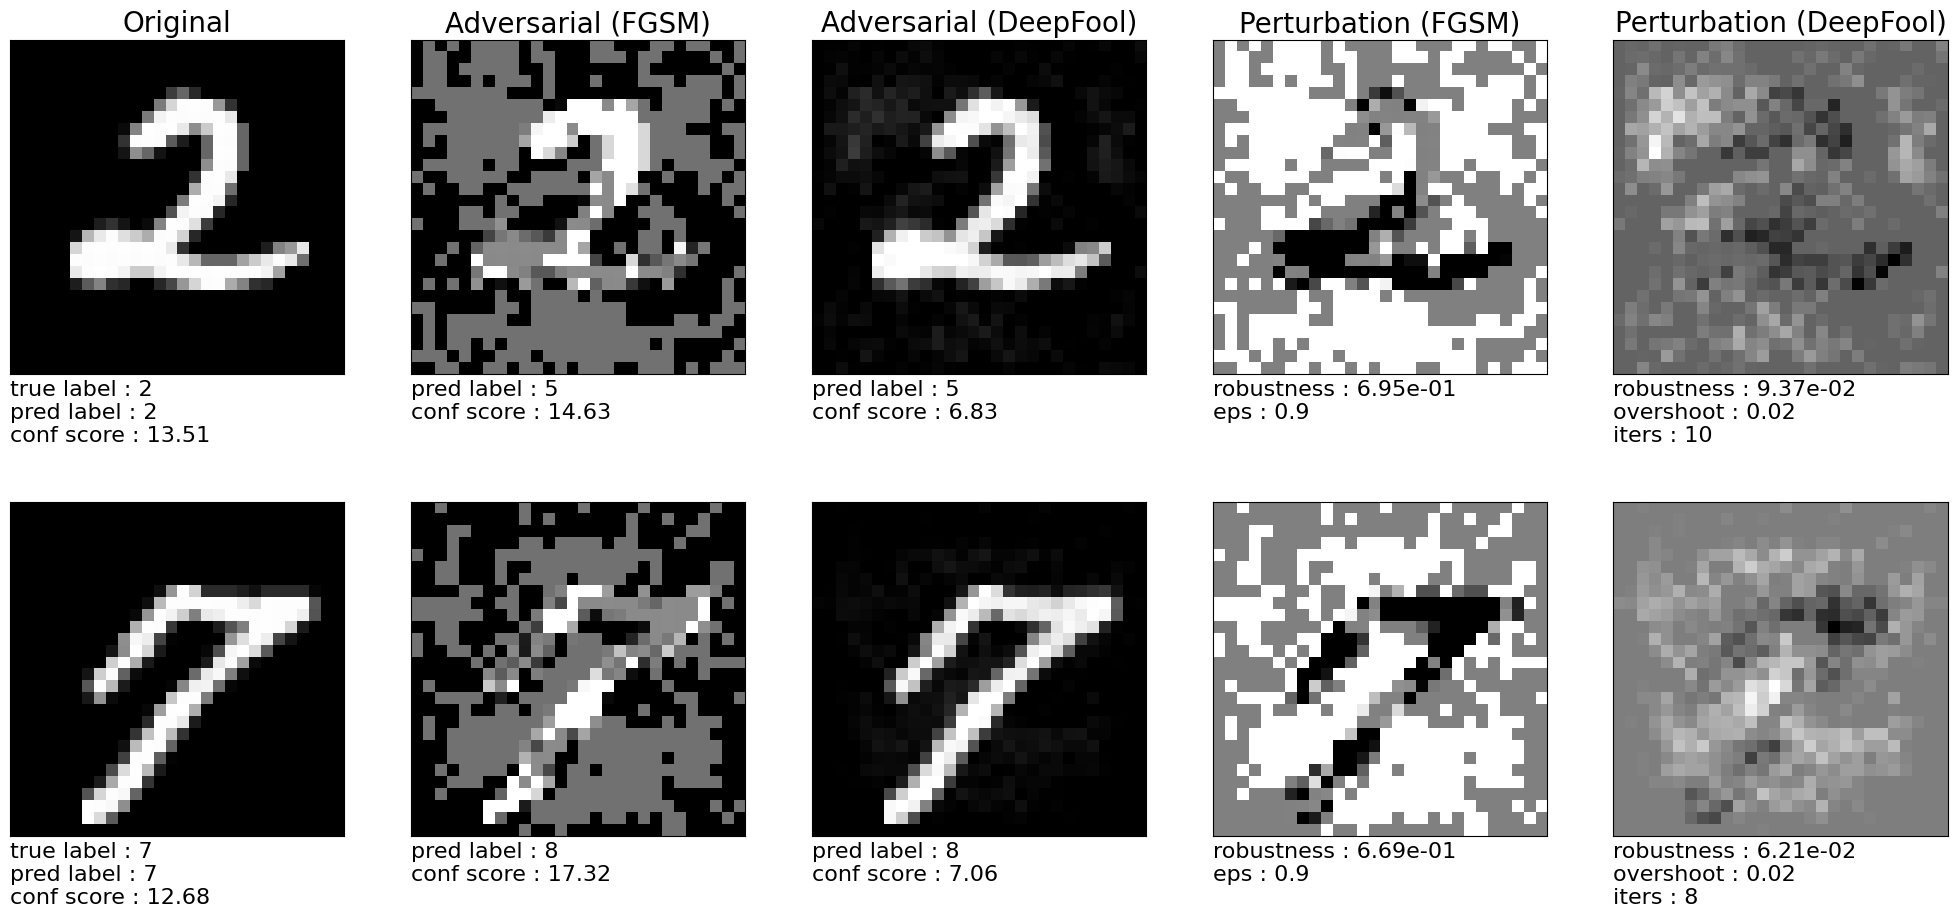

eps:  0.9


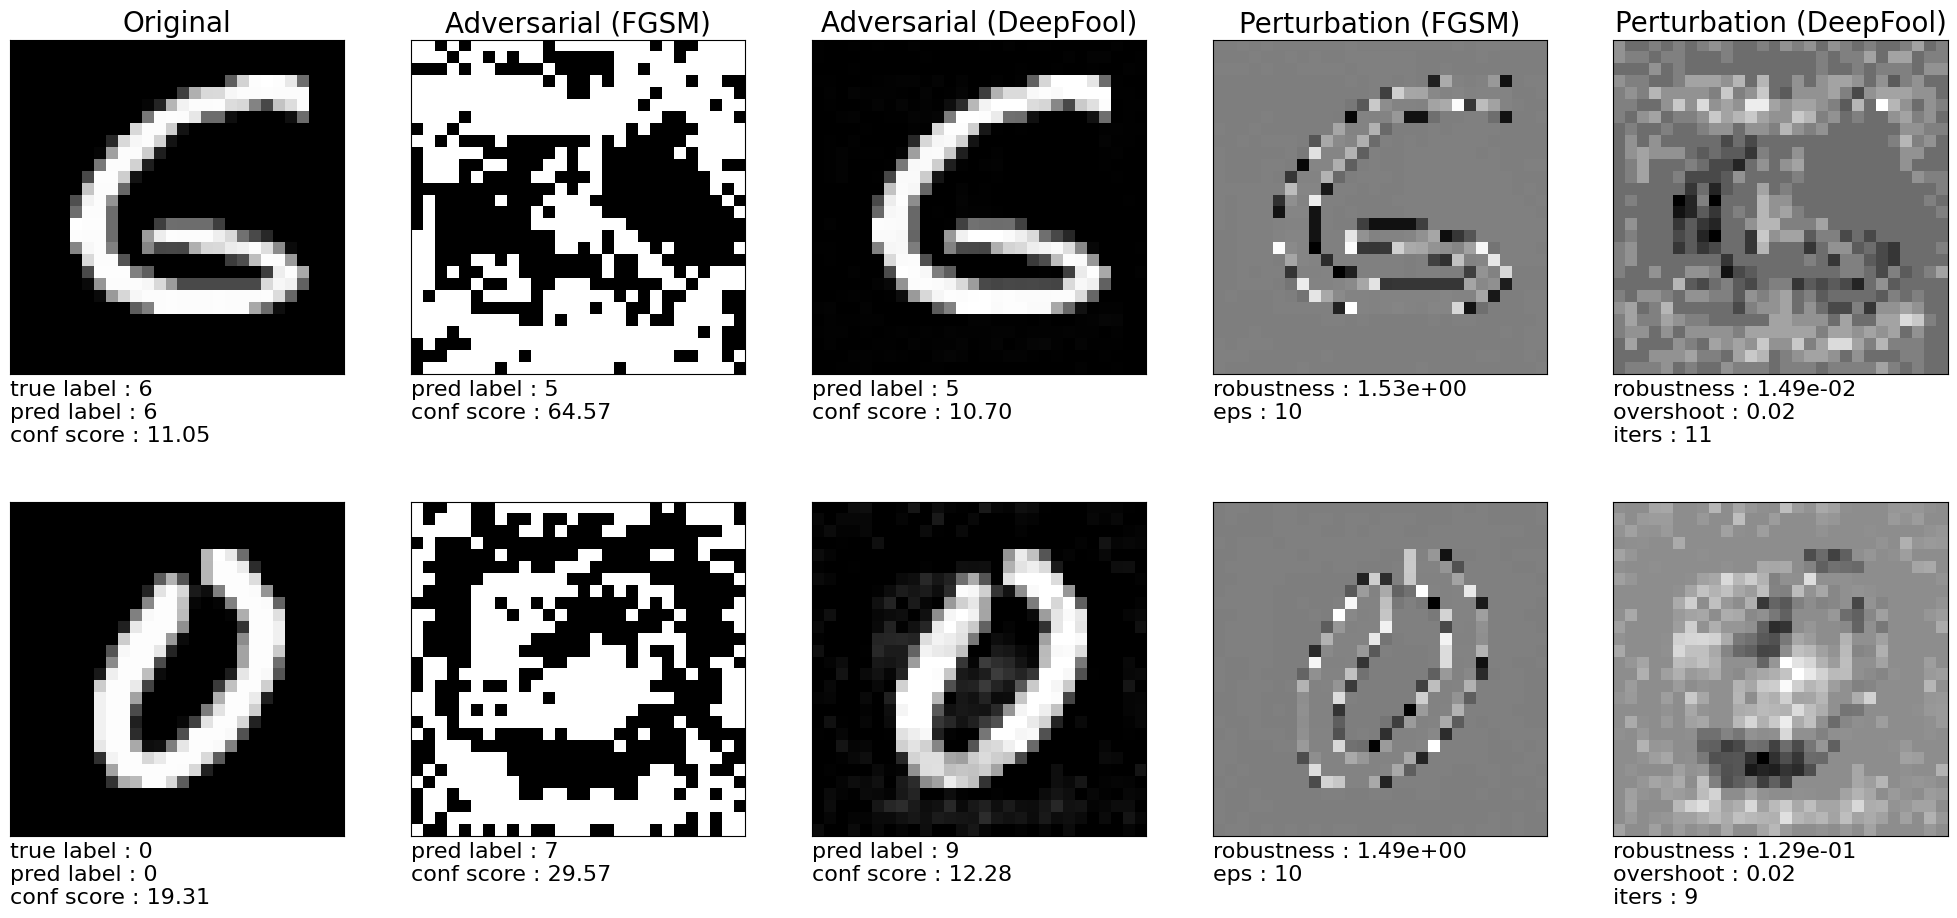

eps:  10


In [33]:
fgsm_eps_arr = [0.001, 0.02, 0.5, 0.9, 10]
for fgsm_eps in fgsm_eps_arr:
  model = FC_500_150().to(device)
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
  display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
  if device.type == 'cuda': torch.cuda.empty_cache()
  print("eps: ", fgsm_eps)

# **Вывод**
### **Сравнив результаты, становится очевидно, что от eps зависит интесивность шума, и при eps < 0.1 FGSM не смог ввести в заблуждение LeNet, хотя и карта шума была почти не заметна.**
### **А при слишком больших eps > 0.4 рисунок станвится крайне зашумленным, и это становится легко обнаружить.***